In [1]:
import os
os.getcwd()

'/Users/yongjunchoi/Documents/GitHub/Research/Research/Polytomy/Codes/Project_1_Polytomy_Resolver_GSM'

- Use `R` version 4.3.3 due to compatibility with packages

- Required block for run `R` in `.ipynb`

In [2]:
## Load rpy2: R to Python
%load_ext rpy2.ipython

import rpy2.robjects as ro
print(ro.r('version'))

Error importing in API mode: ImportError("dlopen(/Users/yongjunchoi/Library/Python/3.9/lib/python/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <08761B8B-0767-3CA6-9437-5468D1CD700F> /Users/yongjunchoi/Library/Python/3.9/lib/python/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


               _                           
platform       aarch64-apple-darwin20      
arch           aarch64                     
os             darwin20                    
system         aarch64, darwin20           
status                                     
major          4                           
minor          3.3                         
year           2024                        
month          02                          
day            29                          
svn rev        86002                       
language       R                           
version.string R version 4.3.3 (2024-02-29)
nickname       Angel Food Cake             



# Goal
- General Sampling Method (GSM)ÏôÄ Binary Random Tree Generating Methods ÎπÑÍµê

# 0. Preprocessing

- Worm atlas
  - url:  https://www.wormatlas.org/celllistsulston.htm
  - Wormatlas -> Resource -> Cell Lists -> C. elegans Cell List
  - ref:  JE and White, JG (1988), "Parts list", in "The Nematode Caenorhabditis elegans, eds WB Wood et al, Cold Spring Harbor Laboratory Press, Cold Spring Harbor, New York, USA, pp 415 - 431
- Ï†ÑÏ≤òÎ¶¨
  - `.`ÏôÄ ` ` ÎèôÏùºÏãú (code)
  - `,`Í∞Ä ÏûàÏùÑ Í≤ΩÏö∞ Î∞ëÏóê Ï∂îÍ∞Ä (code)
  - `/`Í∞Ä ÏûàÏùÑ Í≤ΩÏö∞ Î∞ëÏóê Ï∂îÍ∞Ä (code)
  - `l/r`Í∞Ä ÏûàÏùÑ Í≤ΩÏö∞ `*l*`, `*r*`Î°ú Î∂ÑÎ¶¨ (manually; #: 1359 -> 1369)
    - `Complete_cell_list.csv` -> `Complete_cell_list_LR.csv`
  - Cell Ïù¥ `Z`ÏóêÏÑú ÏïàÏò§Î©¥ Ï†úÍ±∞ (code; #: 1369 -> 1264)
  - Ï§ëÎ≥µ Ï†úÍ±∞ (code; #: 1264 -> 1229)
    - `Complete_cell_list_LR.csv` -> `Complete_cell_list_preprocessed.csv`

In [3]:
import pandas as pd

# CSV Î∂àÎü¨Ïò§Í∏∞
complete_cell_data = pd.read_csv("csv/Complete_cell_list_LR.csv", quotechar='"')

# '.'ÏùÑ Í≥µÎ∞±ÏúºÎ°ú ÎåÄÏ≤¥
complete_cell_data['Lineage Name'] = complete_cell_data['Lineage Name'].str.replace('.', ' ', regex=False)

# ','ÏôÄ '/' Í∏∞Ï§ÄÏúºÎ°ú Î∂ÑÎ¶¨ ÌõÑ Í≥µÎ∞± Ï†úÍ±∞ÌïòÍ≥† explode
complete_cell_data_expanded = complete_cell_data.assign(
    **{
        'Lineage Name': complete_cell_data['Lineage Name']
        .apply(lambda x: [s.strip() for part in x.split(',') for s in part.split('/')])
    }
).explode('Lineage Name').reset_index(drop=True)

# manual_mapping Ï†ïÏùò
manual_mapping = {
    "EMS": ["Z pa"],
    "P1": ["Z p"],
    "P2": ["Z pp"],
    "P3": ["Z ppp"]
}

# manual_mappingÏùÑ DataFrameÏúºÎ°ú Î≥ÄÌôò
manual_df = pd.DataFrame([
    {"Cell": cell, "Lineage Name": lineage}
    for cell, lineages in manual_mapping.items()
    for lineage in lineages
])

# Í∏∞Ï°¥ expanded DataFrameÏóê append
complete_cell_data_expanded = pd.concat([complete_cell_data_expanded, manual_df], ignore_index=True)


# Cell Ïù¥Î¶Ñ ÏßëÌï©
cell_names = set(complete_cell_data_expanded['Cell'].dropna())

# lineage_maps ÏÉùÏÑ±: Cell -> list of Lineages
from collections import defaultdict

lineage_maps = defaultdict(list)
for _, row in complete_cell_data_expanded.iterrows():
    lineage_maps[row['Cell']].append(row['Lineage Name'])

lineage_map_df = pd.DataFrame([
    {'Cell': cell, 'Lineage Names': ','.join(names)}
    for cell, names in lineage_maps.items()
])



In [4]:
# Ïû¨Í∑ÄÏ†ÅÏúºÎ°ú prefix ÍµêÏ≤¥ Î∞è code Ìï©ÏπòÍ∏∞
def resolve_lineage(lineage):
    parts = lineage.split(' ')
    prefix = parts[0]
    codes = ''.join(parts[1:])
    
    if prefix not in lineage_maps:
        return prefix, codes
    else:
        # Ï≤´ Î≤àÏß∏ LineageÎßå Ïû¨Í∑Ä Ï†ÅÏö©
        resolved_prefix, resolved_codes = resolve_lineage(lineage_maps[prefix][0])
        return resolved_prefix, resolved_codes + codes

# Í≤∞Í≥º Ï†ÄÏû•
resolved_data = []
for _, row in complete_cell_data_expanded.iterrows():
    cell = row['Cell']
    lineage = row['Lineage Name']
    prefix, codes = resolve_lineage(lineage)
    resolved_data.append({
        'Cell': cell,
        'Prefix': prefix,
        'Code': codes
    })

resolved_df = pd.DataFrame(resolved_data)

# PrefixÍ∞Ä 'Z'Ïù∏ ÌñâÎßå ÏÑ†ÌÉù
z_only_df = resolved_df[resolved_df['Prefix'] == 'Z'].reset_index(drop=True)

# 'Cell', 'Prefix', 'Code'Í∞Ä Î™®Îëê Í∞ôÏùÄ Ìñâ Ï†úÍ±∞
z_only_df_unique = z_only_df.drop_duplicates(subset=['Cell', 'Prefix', 'Code']).reset_index(drop=True)

# PrefixÏôÄ Code Ìï©ÏπòÍ∏∞
z_only_df_unique['Lineage Name'] = z_only_df_unique['Prefix'] + z_only_df_unique['Code']

# ÌïÑÏöîÌïú Ïó¥Îßå ÏÑ†ÌÉù
z_only_df_unique = z_only_df_unique[['Cell', 'Lineage Name']]

# Ï§ëÎ≥µ Ïù¥Î¶Ñ Ï≤òÎ¶¨
name_count = {}
def make_unique_name(name):
    if name not in name_count:
        name_count[name] = 1
        return name
    else:
        name_count[name] += 1
        return f"{name}_{name_count[name]}"

# Cell Ïª¨ÎüºÏóê Ï†ÅÏö©
z_only_df_unique['Cell'] = z_only_df_unique['Cell'].apply(make_unique_name)

# CSVÎ°ú Ï†ÄÏû•
preprocessed_output_path = "csv/Complete_cell_list_preprocessed.csv"
z_only_df_unique.to_csv(preprocessed_output_path, index=False)

# 1. C. elegans Tree Generation
- `Complete_cell_list_preprocessed.csv` to `tree_all_mapped.nwk`
- `tree_all_mapped.nwk` to `complete_tree.nwk` = `polytomy_removed_tree.nwk`

## 1.1. `.csv` to edges

In [5]:
# csv to edge
import pandas as pd
from collections import Counter
from Bio import Phylo
from collections import defaultdict

df = pd.read_csv("csv/Complete_cell_list_preprocessed.csv")

edges = []

for idx, row in df.iterrows():
    lineage = row['Lineage Name']
    for i in range(1, len(lineage)):
        parent = lineage[:i]       # Î∂ÄÎ™® ÏΩîÎìú
        child  = lineage[:i+1]     # ÏûêÏãù ÏΩîÎìú
        edges.append({'from': parent, 'to': child})

edges_df = pd.DataFrame(edges).drop_duplicates().reset_index(drop=True)

edges_output_path = "csv/edges_list_all.csv"
edges_df.to_csv(edges_output_path, index=False)

## 1.2. edges to `.nwk`

In [6]:
# edge to nwk
edges_df = pd.read_csv("csv/edges_list_all.csv")

tree_dict = defaultdict(list)
for _, row in edges_df.iterrows():
    tree_dict[row['from']].append(row['to'])

def build_newick(node):
    if node not in tree_dict or len(tree_dict[node]) == 0:
        return node
    else:
        children_newick = [build_newick(child) for child in tree_dict[node]]
        return "(" + ",".join(children_newick) + ")" + node

root = 'Z'
newick_str = build_newick(root) + ";"

newick_path = "nwk/answer/tree_all_mapped.nwk"
with open(newick_path, "w") as f:
    f.write(newick_str)

## 1.3. Remove polytomy in `.nwk`
- Finalized Tree
  - `tree_all_mapped.nwk` to `complete_tree.nwk`

In [7]:
# Remove polytomy in nwk
from Bio import Phylo

newick_path = "nwk/answer/tree_all_mapped.nwk"
tree = Phylo.read(newick_path, "newick")

print(".csv to edge tree : Total daughters: ", len(tree.get_terminals()))
print(*[f"{k} daughters: {v} nodes" 
        for k, v in sorted(Counter(len(c.clades) for c in tree.find_clades()).items())], 
      sep=", ")

def num_daughters(clade):
    return len(clade.clades)

def remove_nodes(clade):
    clade.clades = [child for child in clade.clades if num_daughters(child) < 3]
    for child in clade.clades:
        remove_nodes(child)
    return None

print("\nRemoving existing polytomy nodes...\n")
remove_nodes(tree.root)

output_path = "nwk/answer/complete_tree.nwk"
Phylo.write(tree, output_path, "newick")

tree = Phylo.read(output_path, "newick")
print(".csv to edge tree : Total daughters: ", len(tree.get_terminals()))
print(*[f"{k} daughters: {v} nodes" 
        for k, v in sorted(Counter(len(c.clades) for c in tree.find_clades()).items())], 
      sep=", ")

.csv to edge tree : Total daughters:  1099
0 daughters: 1099 nodes, 1 daughters: 170 nodes, 2 daughters: 1066 nodes, 3 daughters: 1 nodes, 4 daughters: 10 nodes

Removing existing polytomy nodes...

.csv to edge tree : Total daughters:  984
0 daughters: 984 nodes, 1 daughters: 164 nodes, 2 daughters: 983 nodes


## 1.4. Check Tree
- (Depth <= 4)
- Assign code to name to check with reference.
- - Resultant tree =  Fig 2 in 'Neuronal Cell Lineages in the Nematode Caenorhabditis elegans (Sulston, 1983)'
  - doi: https://doi.org/10.1101/sqb.1983.048.01.049
  - <img src="https://www.wormatlas.org/SulstonNeuronalCellLineages/art/FIG2s.jpg" style="width:50%; border:1px solid black;">

In [8]:
from Bio import Phylo

# ÏòàÏãú: ÎÖ∏Îìú Ïù¥Î¶Ñ Îß§Ìïë
node_name_map = {
    "Z": "zygote",
    "Za": "AB",
    "Zpa": "EMS",
    "Zpaa": "MS",
    "Zpap": "E",
    "Zppa": "C",
    "Zpppa": "D",
    "Zp": "P1",
    "Zpp": "P2",
    "Zppp": "P3",
    "Zpppp": "P4"
}

# Ïû¨Í∑Ä Ï∂úÎ†• Ìï®Ïàò
def print_tree_mapped(clade, depth=0, max_depth=4):
    if depth > max_depth:
        return
    # clade.nameÏù¥ ÏûàÏúºÎ©¥ Í∑∏ÎåÄÎ°ú, ÏóÜÏúºÎ©¥ Internal ÎòêÎäî Îß§ÌïëÎêú Ïù¥Î¶Ñ
    name = clade.name if clade.name else "Internal"
    # ÎØ∏Î¶¨ Ï†ïÏùòÌïú Ïù¥Î¶ÑÍ≥º Í∞ôÏúºÎ©¥ ÎåÄÏ≤¥
    if name in node_name_map:
        name = node_name_map[name]
    print("  " * depth + f"{name}")
    for child in clade.clades:
        print_tree_mapped(child, depth+1, max_depth)

# Ìä∏Î¶¨ ÏùΩÍ∏∞
tree = Phylo.read("nwk/answer/complete_tree.nwk", "newick")

# depth Ï†úÌïú Ï†ÅÏö© ÌõÑ Ï∂úÎ†•
print_tree_mapped(tree.root, max_depth=4)

zygote
  AB
    Zap
      Zapl
        Zapla
        Zaplp
      Zapr
        Zapra
        Zaprp
    Zaa
      Zaar
        Zaarp
        Zaara
      Zaal
        Zaalp
        Zaala
  P1
    EMS
      E
        Zpapa
        Zpapp
      MS
        Zpaaa
        Zpaap
    P2
      C
        Zppap
        Zppaa
      P3
        D
        P4


- Ï†ÑÏ≤¥ Tree topologyÎßå Îã§Ïãú Ï†ÄÏû• ÌõÑ ÏãúÍ∞ÅÌôî

# 2. Polytomy Analysis

## 2.1. Generate Artificial Polytomy
- In `complete_tree.nwk`, check whether `polytomy_size` leaved node exists.
- Choose one among them.
- Polytomize that node.

- Polytomy parameters

In [9]:
polytomy_size = 25
tree_sample_size = 100

- Load tree and check the number of daughters

In [10]:
from Bio import Phylo
import random
from collections import Counter
from Bio.Phylo.Newick import Clade
import copy

true_tree_path = "nwk/answer/complete_tree.nwk"
true_tree = Phylo.read(true_tree_path, "newick")

print("Total daughters: ", len(tree.get_terminals()))
print(*[f"{k} daughters: {v} nodes" 
        for k, v in sorted(Counter(len(c.clades) for c in tree.find_clades()).items())], 
      sep=", ")

Total daughters:  984
0 daughters: 984 nodes, 1 daughters: 164 nodes, 2 daughters: 983 nodes


- Function to find all nodes with `m` leaves

In [11]:
def find_nodes_with_m_leaves(clade, m):
    nodes = []
    def helper(node):
        if node.is_terminal():
            return 1
        leaf_count = sum(helper(c) for c in node.clades)
        if leaf_count == m:
            nodes.append(node)
        return leaf_count
    helper(clade)
    return nodes

- If there are more than 1 node with leaf size = `polytomy_size`, choose one among them.
- Make that node to polytomy.
- Save 
  - Original copy to `polytomy_removed_tree.nwk`
  - 

In [12]:
copy_tree = copy.deepcopy(true_tree)
nodes_with_m_leaves = find_nodes_with_m_leaves(copy_tree.root, polytomy_size)

print("Before polytomizing: Total daughters: ", len(copy_tree.get_terminals()))
print(*[f"{k} daughters: {v} nodes" 
    for k, v in sorted(Counter(len(c.clades) for c in copy_tree.find_clades()).items())], 
    sep=", ")

if len(nodes_with_m_leaves) == 0:
    print("\nUnable to polytomize!")
else:
    print("\nPolytomizing one of the subtree among {} trees...\n".format(len(nodes_with_m_leaves)))

    def count_children(node):
        counts = Counter()
        child_count = len(node.clades)
        counts[child_count] += 1
        
        for child in node.clades:
            counts.update(count_children(child))
        return counts

    child_counter = count_children(copy_tree.root)

    picked_node = random.choice(nodes_with_m_leaves)

    answer_subtree = copy.deepcopy(picked_node)
    # Î¶¨ÌîÑ ÎÖ∏Îìú Ïù¥Î¶Ñ t1, t2, ...
    for i, leaf in enumerate(answer_subtree.get_terminals(), start=1):
        leaf.name = f"t{i}"

    # ÎÇ¥Î∂Ä ÎÖ∏Îìú Ïù¥Î¶Ñ Ï†úÍ±∞
    for n in answer_subtree.get_nonterminals():
        n.name = None

    # Î™®Îì† branch_length Ï†úÍ±∞ (Ïû¨Í∑Ä)
    def remove_branch_length(clade):
        clade.branch_length = None
        for child in clade.clades:
            remove_branch_length(child)

    remove_branch_length(answer_subtree)
    Phylo.write(answer_subtree, "nwk/answer/polytomy_removed_tree.nwk", "newick")

    # Newick Î¨∏ÏûêÏó¥Î°ú Í∞ÄÏ†∏Ïò§Í∏∞
    from io import StringIO
    output = StringIO()
    Phylo.write(answer_subtree, output, "newick")
    newick_str = output.getvalue()

    # :0.00000 Ï†úÍ±∞
    import re
    newick_str_no_branch = re.sub(r":0\.0+","", newick_str)

    # ÌååÏùºÎ°ú Ï†ÄÏû•
    with open("nwk/answer/polytomy_removed_tree.nwk","w") as f:
        f.write(newick_str_no_branch)

    def polytomize_node(node):
        leaves = node.get_terminals()
        node.clades = leaves

    polytomize_node(picked_node)
    print("After polytomizing: Total daughters: ", len(copy_tree.get_terminals()))
    print(*[f"{k} daughters: {v} nodes" 
        for k, v in sorted(Counter(len(c.clades) for c in copy_tree.find_clades()).items())], 
      sep=", ")

Before polytomizing: Total daughters:  984
0 daughters: 984 nodes, 1 daughters: 164 nodes, 2 daughters: 983 nodes

Polytomizing one of the subtree among 6 trees...

After polytomizing: Total daughters:  984
0 daughters: 984 nodes, 1 daughters: 159 nodes, 2 daughters: 959 nodes, 25 daughters: 1 nodes


## 2.2. Generate Trees for each Method

- As the resolved tree for polytomy, generate simulated trees for each method.
  - Birth-death model (BD)
  - Beta-splitting model (BT)
  - Kingman Coalescent model (KC)
  - Yule model (YL)
  - Uniform model (UF)

In [13]:
%%R -i polytomy_size -i tree_sample_size
library(ape)
library(poweRbal)

leaves <- polytomy_size
reps   <- tree_sample_size
path <- "nwk/simulation"
if (!dir.exists(path)) dir.create(path, recursive = TRUE)

# Î™®Îç∏Í≥º ÌååÎùºÎØ∏ÌÑ∞Î•º Î¶¨Ïä§Ìä∏Î°ú Ï†ïÏùò
models <- list(
  list(name="BD", type="BD", params=data.frame(birth=c(1,2), death=c(0,0.5))),
  list(name="BT", type="Beta", params=data.frame(beta=c(0.2,0.5))),
  list(name="KC", type="KC", params=NULL),
  list(name="YL", type="Yule", params=NULL),
  list(name="UF", type="Uniform", params=NULL)
)

for (m in models) {
  model <- m$name
  type  <- m$type
  params <- m$params
  
  if (type=="BD") {
    for (i in 1:nrow(params)) {
      b <- params$birth[i]
      d <- params$death[i]
      trees <- lapply(1:reps, function(j) genAltBirthDeathTree(n=leaves, BIRTHRATE=b, DEATHRATE=d, TRIES=1000))
      file_name <- sprintf("%s_b%.1f_d%.1f_l%d_r%d.nwk", model, b, d, leaves, reps)
      write.tree(trees, file=file.path(path, file_name))
      cat("Saved:", file_name, "\n")
    }
  } else if (type=="Beta") {
    for (i in 1:nrow(params)) {
      b <- params$beta[i]
      trees <- lapply(1:reps, function(j) genAldousBetaTree(n=leaves, BETA=b))
      file_name <- sprintf("%s_b%.1f_l%d_r%d.nwk", model, b, leaves, reps)
      write.tree(trees, file=file.path(path, file_name))
      cat("Saved:", file_name, "\n")
    }
  } else if (type=="KC") {
    trees <- lapply(1:reps, function(j) {
      tr <- rcoal(n=leaves)
      tr$edge.length <- NULL
      tr
    })
    file_name <- sprintf("%s_l%d_r%d.nwk", model, leaves, reps)
    write.tree(trees, file=file.path(path, file_name))
    cat("Saved:", file_name, "\n")
    
  } else if (type=="Yule") {
    trees <- lapply(1:reps, function(j) genAldousBetaTree(n=leaves, BETA=0))
    file_name <- sprintf("%s_l%d_r%d.nwk", model, leaves, reps)
    write.tree(trees, file=file.path(path, file_name))
    cat("Saved:", file_name, "\n")
    
  } else if (type=="Uniform") {
    trees <- lapply(1:reps, function(j) genAldousBetaTree(n=leaves, BETA=-1.5))
    file_name <- sprintf("%s_l%d_r%d.nwk", model, leaves, reps)
    write.tree(trees, file=file.path(path, file_name))
    cat("Saved:", file_name, "\n")
  }
}

Saved: BD_b1.0_d0.0_l25_r100.nwk 
Saved: BD_b2.0_d0.5_l25_r100.nwk 
Saved: BT_b0.2_l25_r100.nwk 
Saved: BT_b0.5_l25_r100.nwk 
Saved: KC_l25_r100.nwk 
Saved: YL_l25_r100.nwk 
Saved: UF_l25_r100.nwk 


- Rename generated trees for easier use.

In [14]:
import os
from glob import glob

tree_folder = "nwk/simulation"
prefixes = ["BD", "BT", "KC", "YL", "UF"]

# Î™®Îç∏Î≥ÑÎ°ú ÌååÏùº Î¶¨Ïä§Ìä∏ ÎßåÎì§Í∏∞
all_files = sorted(glob(os.path.join(tree_folder, "*.nwk")))

# Í∞Å Î™®Îç∏Î≥ÑÎ°ú Í∑∏Î£πÌôî
model_files = []
for p in prefixes:
    files = sorted([f for f in all_files 
                    if os.path.basename(f).startswith(p) 
                    and f"l{polytomy_size}" in os.path.basename(f)])
    model_files.extend(files)  # ÏàúÏÑúÎåÄÎ°ú ÌïòÎÇòÏùò Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä

# model_1, model_2, ... Î≥ÄÏàò ÏÉùÏÑ±
for i, fpath in enumerate(model_files, start=1):
    globals()[f"model_{i}"] = fpath

# models Î¶¨Ïä§Ìä∏Ïóê Îã¥Í∏∞
models = [globals()[f"model_{i}"] for i in range(1, len(model_files)+1)]

# ÌôïÏù∏
for i, f in enumerate(models, start=1):
    print(f"model_{i}: {f}")

model_1: nwk/simulation/BD_b1.0_d0.0_l25_r100.nwk
model_2: nwk/simulation/BD_b2.0_d0.5_l25_r100.nwk
model_3: nwk/simulation/BT_b0.2_l25_r100.nwk
model_4: nwk/simulation/BT_b0.5_l25_r100.nwk
model_5: nwk/simulation/KC_l25_r100.nwk
model_6: nwk/simulation/YL_l25_r100.nwk
model_7: nwk/simulation/UF_l25_r100.nwk


## 2.3. Calculate & Plot Statistics

### 2.3.1. 1D Statistics
- Colless Index
- Sackins Index
- Tree Height
- Root Splitting Ratio

- Define Functions for 1D Statistics

In [15]:
import dendropy
import math

def colless_index(tree):
    def count_leaves(node):
        if node.is_leaf():
            return 1
        return sum(count_leaves(c) for c in node.child_nodes())

    def colless_node(node):
        if node.is_leaf() or len(node.child_nodes()) < 2:
            return 0
        left, right = node.child_nodes()[:2]  # binary assumption
        nl = count_leaves(left)
        nr = count_leaves(right)
        return abs(nl - nr) + colless_node(left) + colless_node(right)

    return colless_node(tree.seed_node)

def sackins_index(tree):
    def leaf_depth_sum(node, depth=0):
        if node.is_leaf():
            return depth
        return sum(leaf_depth_sum(c, depth+1) for c in node.child_nodes())

    return leaf_depth_sum(tree.seed_node)

def tree_height(tree):
    max_depth = 0
    def dfs(nd, depth):
        nonlocal max_depth
        if nd.is_leaf():
            max_depth = max(max_depth, depth)
        for c in nd.child_nodes():
            dfs(c, depth+1)
    dfs(tree.seed_node, 0)
    return max_depth

def root_split_ratio_x(tree):
    root_children = tree.seed_node.child_nodes()
    if len(root_children) >= 2:
        n_left = len(root_children[0].leaf_nodes())
        n_right = len(root_children[1].leaf_nodes())
    elif len(root_children) == 1:
        n_left = len(root_children[0].leaf_nodes())
        n_right = 0
    else:
        n_left = 0
        n_right = 0

    # ÏôºÏ™ΩÏùÑ Ìï≠ÏÉÅ ÏûëÏùÄ Ï™ΩÏúºÎ°ú
    if n_left > n_right:
        n_left, n_right = n_right, n_left

    return n_left  # x Í∞íÎßå Î∞òÌôò

- Calculate 1D Statistics

In [16]:
import dendropy
import pandas as pd

# Î™®Îç∏Î≥Ñ ÌååÏùº Î¶¨Ïä§Ìä∏
# models = [model_1, model_2, ...] Ïù¥ÎØ∏ Ï°¥Ïû¨ÌïúÎã§Í≥† Í∞ÄÏ†ï
model_labels = [f"model_{i}" for i in range(1, len(models)+1)]

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï¥àÍ∏∞Ìôî
df_stats = pd.DataFrame(columns=["Model", "Colless", "Sackin", "Height", "RootSplit"])

for label, fpath in zip(model_labels, models):
    # ÌååÏùº ÌïòÎÇòÏóê Ïó¨Îü¨ Ìä∏Î¶¨Í∞Ä ÏûàÏúºÎ©¥ TreeListÎ°ú ÏùΩÍ∏∞
    trees = dendropy.TreeList.get(path=fpath, schema="newick", preserve_underscores=True)
    for tree in trees:
        df_stats.loc[len(df_stats)] = {
            "Model": label,
            "Colless": colless_index(tree),
            "Sackin": sackins_index(tree),
            "Height": tree_height(tree),
            "RootSplit": root_split_ratio_x(tree)
        }

# polytomy_removed_tree.nwk ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
answer_tree_path = "nwk/answer/polytomy_removed_tree.nwk"
answer_tree = dendropy.Tree.get(path=answer_tree_path, schema="newick", preserve_underscores=True)

answer_stats = {
    "Colless": colless_index(answer_tree),
    "Sackin": sackins_index(answer_tree),
    "Height": tree_height(answer_tree),
    "RootSplit": root_split_ratio_x(answer_tree)
}

# df_stats ÌôïÏù∏
print(df_stats.head())

     Model  Colless  Sackin  Height  RootSplit
0  model_1       63     147       9          8
1  model_1       79     159      10          3
2  model_1       31     127       7          5
3  model_1       43     137       7          3
4  model_1       41     133       9         11


- Plot 1D Statistics

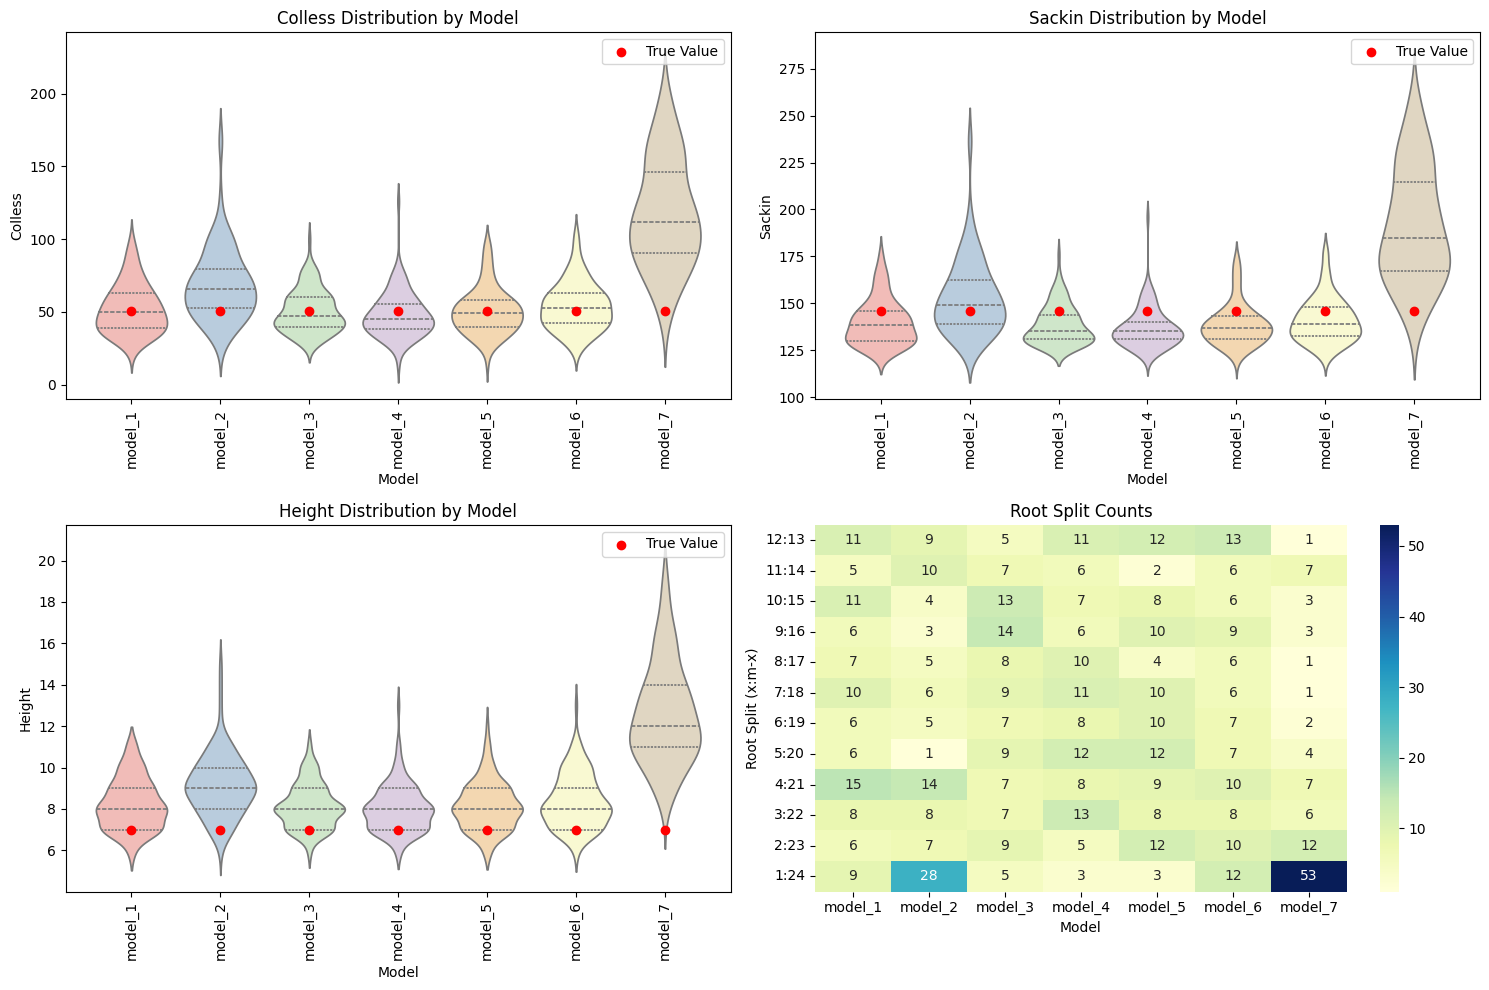

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# -----------------------------
# 1. Í∑∏Î¶¥ Î©îÌä∏Î¶≠ ÏÑ§Ï†ï
# -----------------------------
metrics = ["Colless", "Sackin", "Height"]
model_labels = df_stats['Model'].unique()

# -----------------------------
# 2. 2x2 Figure ÏÑ§Ï†ï
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# -----------------------------
# 3. Violin plots for Colless, Sackin, Height
# -----------------------------
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.violinplot(
        x="Model",
        y=metric,
        data=df_stats,
        inner="quartile",
        order=model_labels,
        palette="Pastel1",
        ax=ax
    )
    # Ï†ïÎãµ Ìä∏Î¶¨ ÌëúÏãú
    ax.scatter(
        x=range(len(model_labels)),
        y=[answer_stats[metric]]*len(model_labels),
        color='red',
        zorder=10,
        label="True Value"
    )
    ax.set_title(f"{metric} Distribution by Model")
    ax.set_xticks(range(len(model_labels)))
    ax.set_xticklabels(model_labels, rotation=90)

    ax.legend()

# -----------------------------
# 4. Heatmap for Root Split
# -----------------------------
m = polytomy_size  # Ï†ÑÏ≤¥ leaf Ïàò

# pivot table: Ìñâ=RootSplit, Ïó¥=Model
heat_data = df_stats.pivot_table(
    index='RootSplit',
    columns='Model',
    aggfunc='size',
    fill_value=0
)

# yÏ∂ï Ï†ïÎ†¨ (1Ïù¥ Í∞ÄÏû• ÏïÑÎûò)
heat_data = heat_data.sort_index(ascending=False)

ax = axes[1,1]
sns.heatmap(
    heat_data,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    ax=ax
)

# yÏ∂ï tickÏùÑ x:(m-x) ÌòïÌÉúÎ°ú Î≥ÄÌôò
y_labels = [f"{x}:{m-x}" for x in heat_data.index]
ax.set_yticklabels(y_labels, rotation=0)

ax.set_title("Root Split Counts")
ax.set_xlabel("Model")
ax.set_ylabel("Root Split (x:m-x)")

plt.tight_layout()
plt.show()

### 2.3.2. 2D Statistics

#### 2.3.2.1. Calculation

##### 2.3.2.1.1 RF Distance

- Calculate 2D statistics (RF distance)

In [18]:
from dendropy import Tree, TreeList, TaxonNamespace
from dendropy.calculate import treecompare
import matplotlib.pyplot as plt

# -----------------------------
# 1. Ï†ïÎãµ Ìä∏Î¶¨ Î°úÎìú
# -----------------------------
answer_tree_path = "nwk/answer/polytomy_removed_tree.nwk"

# Í≥µÌÜµ TaxonNamespace
taxa = TaxonNamespace()

# Ï†ïÎãµ Ìä∏Î¶¨ Î°úÎìú
answer_tree = Tree.get(path=answer_tree_path, schema="newick", taxon_namespace=taxa, preserve_underscores=True)
for e in answer_tree.postorder_edge_iter():
    e.length = None  # edge lengths Ï†úÍ±∞

# -----------------------------
# 2. Î™®Îç∏Î≥Ñ Ìä∏Î¶¨ RF Í±∞Î¶¨ Í≥ÑÏÇ∞
# -----------------------------
rf_distances = []
nrf_distances = []

for model_files in models:  # models Î¶¨Ïä§Ìä∏, Í∞Å ÏöîÏÜåÎäî ÌååÏùº Í≤ΩÎ°ú Î¶¨Ïä§Ìä∏
    if isinstance(model_files, str):
        model_files = [model_files]
    
    dists = []
    n_dists = []
    for f in model_files:
        # ÌååÏùº ÎÇ¥ Î™®Îì† Ìä∏Î¶¨ ÏùΩÍ∏∞
        trees = TreeList.get(path=f, schema="newick", taxon_namespace=taxa, preserve_underscores=True)
        for t in trees:
            # edge lengths Ï†úÍ±∞
            for e in t.postorder_edge_iter():
                e.length = None
            # RF Í±∞Î¶¨ Í≥ÑÏÇ∞
            rf = treecompare.symmetric_difference(answer_tree, t)
            n_leaves = len(t.leaf_nodes())
            rf_norm = rf / (2 * (n_leaves - 3))

            dists.append(rf)
            n_dists.append(rf_norm)
    rf_distances.append(dists)
    nrf_distances.append(n_dists)

##### 2.3.2.1.2. Quartet Distance

- Calculate 2D statistics (Quartet distance)

In [19]:
%%R -i answer_tree_path -i models -o qds -o nqds

library(ape)
library(Quartet)

# Ï†ïÎãµ Ìä∏Î¶¨ ÏùΩÍ∏∞
answer_tree <- read.tree(answer_tree_path)

qds <- list()   # Í∞Å ÌååÏùºÎ≥Ñ Quartet Distance
nqds <- list()  # Ï†ïÍ∑úÌôîÎêú QD

for (i in seq_along(models)) {
  file_path <- models[[i]]  # ÌååÏùº Í≤ΩÎ°ú
  tree_lines <- readLines(file_path)  # ÌååÏùº ÎÇ¥ Î™®Îì† Ìä∏Î¶¨ (Ìïú Ï§ÑÏóê ÌïòÎÇò)
  
  qd_vec <- numeric(length(tree_lines))
  nqd_vec <- numeric(length(tree_lines))
  
  for (j in seq_along(tree_lines)) {
    tr_text <- tree_lines[j]
    
    # Newick Î¨∏ÏûêÏó¥ÏùÑ Í∞ùÏ≤¥Î°ú ÏùΩÍ∏∞
    tr <- read.tree(text = tr_text)
    num_leaves <- length(tr$tip.label)
    
    # Quartet distance Í≥ÑÏÇ∞
    # ÌååÏùº Í≤ΩÎ°ú ÎåÄÏã† ÏûÑÏãú ÌååÏùº ÌïÑÏöî
    tmp_file <- tempfile(fileext = ".nwk")
    writeLines(tr_text, tmp_file)
    qd_val <- QuartetDistance(answer_tree_path, tmp_file)
    unlink(tmp_file)
    
    qd_vec[j] <- qd_val
    nqd_vec[j] <- qd_val / choose(num_leaves, 4)
  }
  
  qds[[i]] <- qd_vec
  nqds[[i]] <- nqd_vec
}
print(length(qds[[1]]))
print(length(nqds[[1]]))

[1] 100
[1] 100


ÌïÑÏöîÌïú Ìå®ÌÇ§ÏßÄÎ•º Î°úÎî©Ï§ëÏûÖÎãàÎã§: TreeTools


#### 2.3.2.2. Plot

- Plot 2D Statistics

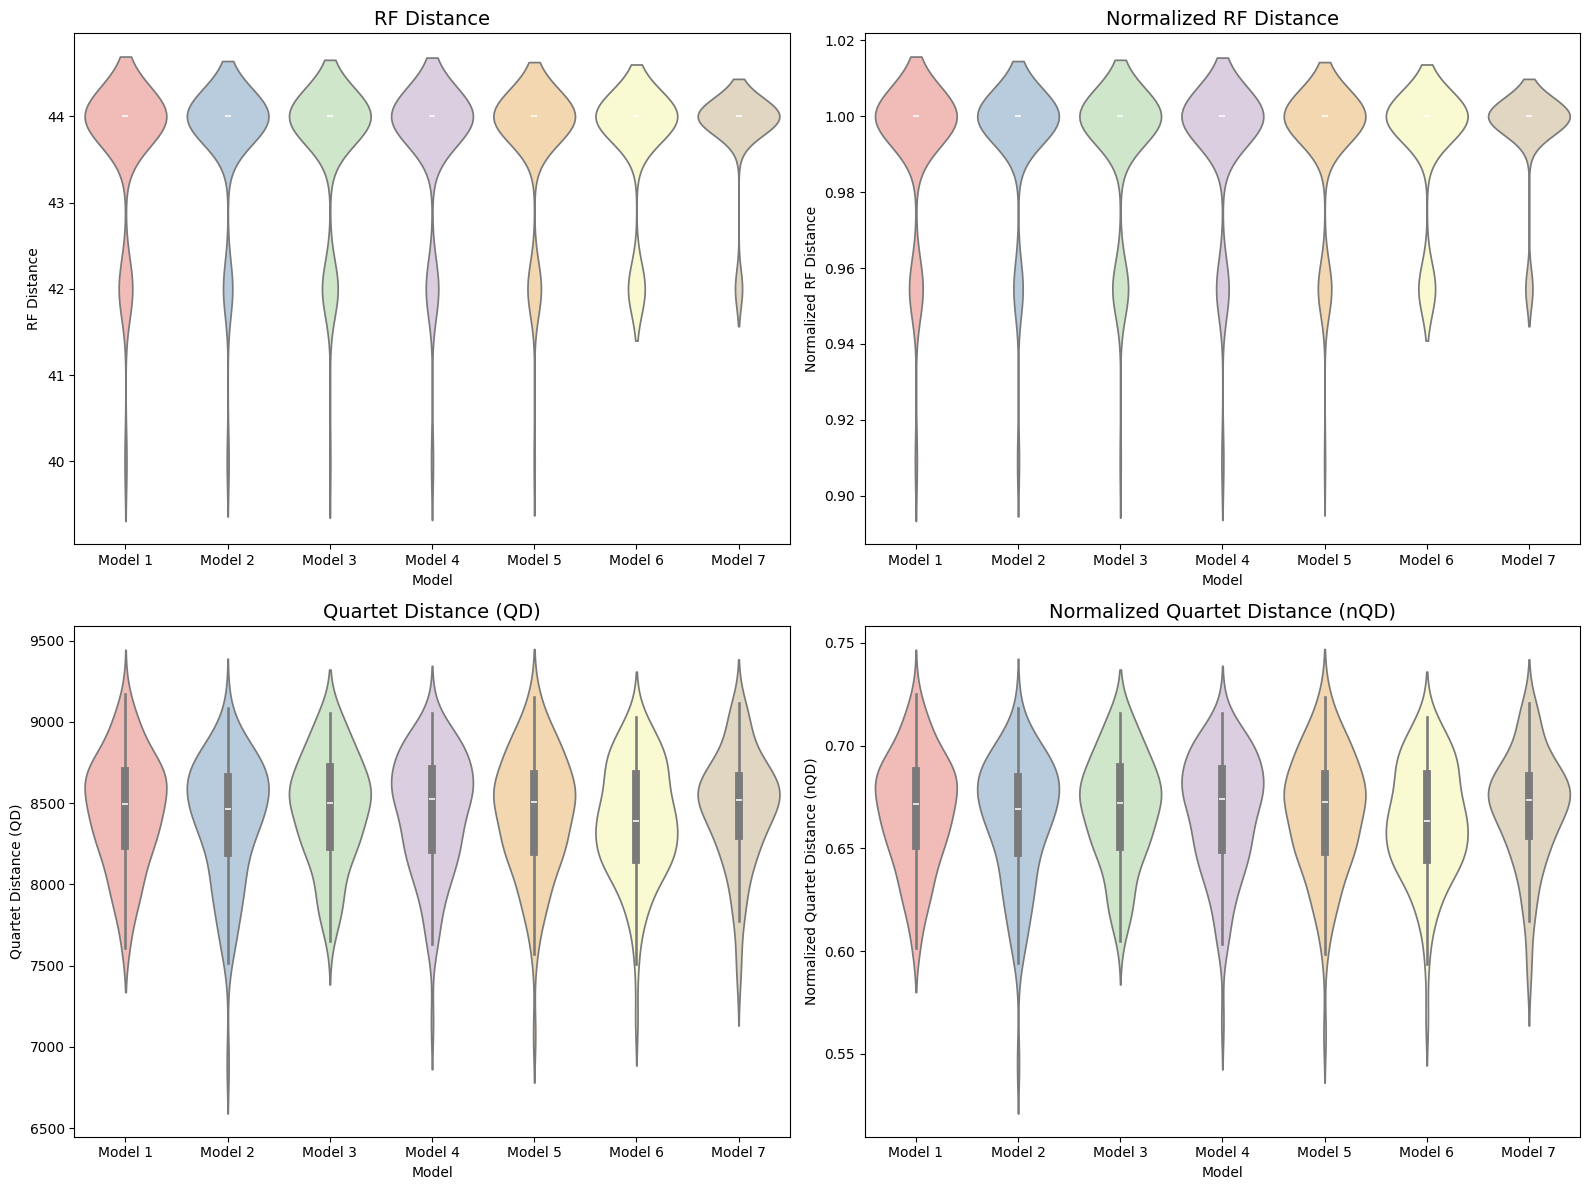

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

# Í≤ΩÍ≥† Ïà®Í∏∞Í∏∞
warnings.filterwarnings("ignore")

# subplot ÏÑ§Ï†ï
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # 1Ï∞®Ïõê Î∞∞Ïó¥Î°ú

# Í∑∏Î¶¥ Îç∞Ïù¥ÌÑ∞ÏôÄ Ïù¥Î¶Ñ
data_metrics = [
    (rf_distances, "RF Distance"),
    (nrf_distances, "Normalized RF Distance"),
    (qds, "Quartet Distance (QD)"),
    (nqds, "Normalized Quartet Distance (nQD)")
]

for ax, (data_list, metric_name) in zip(axes, data_metrics):
    # Î™®Îç∏ Ïù¥Î¶Ñ
    model_labels = [f"Model {i+1}" for i in range(len(data_list))]
    
    # long-form Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
    df = pd.DataFrame({
        "Value": [v for model in data_list for v in model],
        "Model": [model_labels[i] for i, model in enumerate(data_list) for _ in model]
    })
    
    sns.violinplot(x="Model", y="Value", data=df, inner="box", palette="Pastel1", ax=ax)
    ax.set_title(metric_name, fontsize=14)
    ax.set_xlabel("Model")
    ax.set_ylabel(metric_name)

plt.tight_layout()
plt.show()

## 2.4. GSM Distribution Estimation

- Required function

In [21]:
def resolve_polytomy(clade):
    """PolytomyÎ•º binaryÎ°ú Î≥ÄÌôò"""
    if clade.is_terminal():
        return
    
    while len(clade.clades) > 2:
        # Îëê Í∞ú ÏûêÏãùÎßå ÎÇ®Í∏∞Í≥† ÎÇòÎ®∏ÏßÄÎäî ÏÉàÎ°úÏö¥ ÎÇ¥Î∂Ä ÎÖ∏ÎìúÎ°ú Î¨∂Í∏∞
        first = clade.clades.pop(0)
        second = clade.clades.pop(0)
        new_internal = Clade()
        new_internal.clades = [first, second]
        clade.clades.insert(0, new_internal)
    
    # Ïû¨Í∑Ä Ï†ÅÏö©
    for child in clade.clades:
        resolve_polytomy(child)

### 2.4.1. Unweighted Distribution
- Read original tree.
- Check the split-ratio distribution (=`Unweighted`)

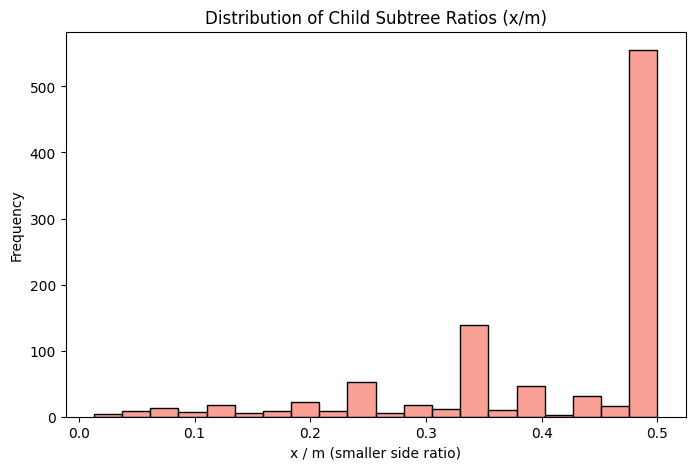

In [22]:
from Bio import Phylo
import matplotlib.pyplot as plt
import seaborn as sns

# Ìä∏Î¶¨ Î∂àÎü¨Ïò§Í∏∞ (ÏòàÏãú: Newick ÌååÏùº)
temp_tree = copy.deepcopy(true_tree)
# resolve_polytomy(temp_tree.root)

ratios = []

def count_leaves(clade):
    """Ïû¨Í∑ÄÏ†ÅÏúºÎ°ú leaf Í∞úÏàò ÏÑ∏Í∏∞"""
    if clade.is_terminal():
        return 1
    return sum(count_leaves(child) for child in clade.clades)

# ÎÇ¥Î∂Ä ÎÖ∏Îìú ÏàúÌöå
for clade in temp_tree.root.find_clades(order="postorder"):
    if not clade.is_terminal() and len(clade.clades) == 2:  # binary nodeÎßå
        left, right = clade.clades
        left_leaves = count_leaves(left)
        right_leaves = count_leaves(right)
        m = left_leaves + right_leaves
        x = min(left_leaves, right_leaves)
        ratio = x / m
        ratios.append(ratio)

# -----------------------------
# Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
# -----------------------------
plt.figure(figsize=(8, 5))
sns.histplot(ratios, bins=20, color="salmon", edgecolor="black")
plt.title("Distribution of Child Subtree Ratios (x/m)")
plt.xlabel("x / m (smaller side ratio)")
plt.ylabel("Frequency")
plt.show()

### 2.4.2. Weighted Distribution
- Read original tree.
- WeightÎ•º frequencyÏóê Î∂ÄÏó¨Ìï¥ distribution ÌôïÏù∏ (=`weighted`)
  - w_root = 1
  - w_Za = 3/8, w_Zp = 5/8 if root split ratio = 3:5
    - w_Zaa = 3/8 * 2/8, w_Zap = 3/8 * 6/8 if split ratio of Za = 2:6

Text(0.5, 1.0, 'Weighted Distribution of Child Subtree Ratios (x/m)')

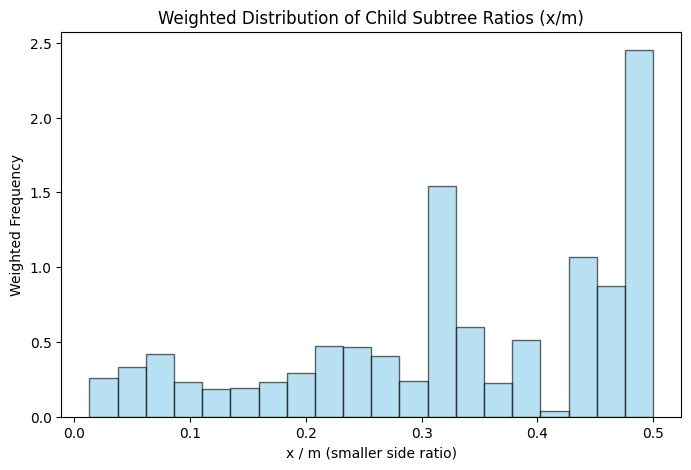

In [23]:
from Bio import Phylo
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# -----------------------------
# Ìä∏Î¶¨ Î∂àÎü¨Ïò§Í∏∞
# -----------------------------
temp_tree = copy.deepcopy(true_tree)  # ÏòàÏãú Ìä∏Î¶¨, Newick Î∂àÎü¨Ïò® ÌõÑ
# resolve_polytomy(tree.root)      # polytomy Ï†úÍ±∞

# -----------------------------
# 1. Bottom-up leaf count Í≥ÑÏÇ∞
# -----------------------------
def compute_leaf_counts(node):
    """Í∞Å ÎÖ∏ÎìúÏóê leaf Í∞úÏàò Ï†ÄÏû• (bottom-up)"""
    if node.is_terminal():
        node.num_leaves = 1
    else:
        node.num_leaves = sum(compute_leaf_counts(child) for child in node.clades)
    return node.num_leaves

compute_leaf_counts(temp_tree.root)

# -----------------------------
# 2. Top-down weighted ratio Í≥ÑÏÇ∞
# -----------------------------
ratios = []
weights = []

def collect_ratios(node, parent_weight=1.0):
    """top-downÏúºÎ°ú weight Ï†ÑÎã¨ÌïòÎ©∞ ratio ÏàòÏßë"""
    if node.is_terminal() or len(node.clades) != 2:
        return

    left, right = node.clades
    left_leaves = left.num_leaves
    right_leaves = right.num_leaves
    m = left_leaves + right_leaves
    x = min(left_leaves, right_leaves)
    ratio = x / m

    # ÌòÑÏû¨ ÎÖ∏ÎìúÏùò weight
    left_weight = parent_weight * (left_leaves / m)
    right_weight = parent_weight * (right_leaves / m)

    # ratioÏôÄ weight Ï†ÄÏû•
    ratios.append(ratio)
    weights.append(parent_weight)  # frequency Í≥ÑÏÇ∞ Ïãú Í≥±Ìï† weight

    # Ïû¨Í∑Ä Ìò∏Ï∂ú
    collect_ratios(left, left_weight)
    collect_ratios(right, right_weight)

collect_ratios(temp_tree.root)

import numpy as np
from scipy.stats import gaussian_kde

# Î¶¨Ïä§Ìä∏ ‚Üí numpy Î∞∞Ïó¥
ratios_arr = np.array(ratios)
weights_arr = np.array(weights)

# -----------------------------
# 1. Weighted histogram
# -----------------------------
plt.figure(figsize=(8,5))
plt.hist(ratios_arr, bins=20, weights=weights_arr, color='skyblue', edgecolor='black', alpha=0.6)
plt.xlabel("x / m (smaller side ratio)")
plt.ylabel("Weighted Frequency")
plt.title("Weighted Distribution of Child Subtree Ratios (x/m)")

## 2.5. GSM Tree Generation
- Distribution from given data

- polytomyÍ∞Ä ÏïÑÎãå Ìä∏Î¶¨Î°úÎ∂ÄÌÑ∞ GSMÏùò distribution Í≥ÑÏÇ∞
- `unweighted`, `weighted`ÏóêÏÑú ÎÇòÎàÑÎäî ÎπÑÏú® samplingÌïòÍ∏∞

In [24]:
import numpy as np

# Ïù¥ÎØ∏ Í≥ÑÏÇ∞Îêú ratiosÏôÄ weightsÎ•º ÏÇ¨Ïö©ÌïúÎã§Í≥† Í∞ÄÏ†ï
# ratios: list of x/m
# weights: list of top-down weight

ratios_arr = np.array(ratios)
weights_arr = np.array(weights)

# -----------------------------
# 1. Unweighted ÏÉòÌîåÎßÅ (ÎåÄÏπ≠ Ìè¨Ìï®)
# -----------------------------
def sample_ratio_unweighted_symmetric(size=1):
    samples = np.random.choice(ratios_arr, size=size)
    # 50% ÌôïÎ•†Î°ú 1 - ratioÎ°ú Îí§ÏßëÍ∏∞
    flip = np.random.rand(size) < 0.5
    samples[flip] = 1 - samples[flip]
    return samples

# -----------------------------
# 2. Weighted ÏÉòÌîåÎßÅ (ÎåÄÏπ≠ Ìè¨Ìï®)
# -----------------------------
def sample_ratio_weighted_symmetric(size=1):
    probs = weights_arr / np.sum(weights_arr)
    samples = np.random.choice(ratios_arr, size=size, p=probs)
    flip = np.random.rand(size) < 0.5
    samples[flip] = 1 - samples[flip]
    return samples

- `weighted`, `unweighted`Î°úÎ∂ÄÌÑ∞ Ìä∏Î¶¨ ÎßåÎì§Í∏∞ Î∞è Ï†ÄÏû•

In [25]:
from Bio.Phylo.Newick import Clade, Tree
import numpy as np

# -----------------------------
# 1. symmetric ratio ÏÉòÌîåÎßÅ Ìï®Ïàò
# -----------------------------
def sample_ratio_unweighted_symmetric(size=1):
    """
    Unweighted sampling, symmetric around 0.5
    """
    samples = np.random.choice(ratios_arr, size=size)
    flip = np.random.rand(size) < 0.5
    samples[flip] = 1 - samples[flip]
    return samples

def sample_ratio_weighted_symmetric(size=1):
    """
    Weighted sampling with symmetric flipping
    """
    probs = weights_arr / np.sum(weights_arr)
    samples = np.random.choice(ratios_arr, size=size, p=probs)
    flip = np.random.rand(size) < 0.5
    samples[flip] = 1 - samples[flip]
    return samples

# -----------------------------
# 2. Ïû¨Í∑ÄÏ†ÅÏúºÎ°ú Ìä∏Î¶¨ ÏÉùÏÑ± (ÏïàÏ†ÑÌïòÍ≤å)
# -----------------------------
def build_tree_general(n_leaves, sample_func, leaf_counter):
    if n_leaves == 1:
        leaf_name = f"t{leaf_counter[0]}"
        leaf_counter[0] += 1
        return Clade(name=leaf_name)

    # ratio ÏÉòÌîåÎßÅ
    ratio = sample_func(size=1)[0]

    # leaf Ïàò Í≥ÑÏÇ∞
    left_leaves = int(round(n_leaves * ratio))
    right_leaves = n_leaves - left_leaves

    # ÌïúÏ™ΩÏù¥ 0Ïù¥Î©¥ ÏµúÏÜå 1Î°ú Î≥¥Ï†ï
    if left_leaves == 0:
        left_leaves = 1
        right_leaves = n_leaves - 1
    elif right_leaves == 0:
        right_leaves = 1
        left_leaves = n_leaves - 1

    left_clade = build_tree_general(left_leaves, sample_func, leaf_counter)
    right_clade = build_tree_general(right_leaves, sample_func, leaf_counter)

    return Clade(clades=[left_clade, right_clade])

# -----------------------------
# 3. branch length ÏóÜÎäî Newick ÏÉùÏÑ±
# -----------------------------
def clade_to_newick(clade):
    if clade.is_terminal():
        return clade.name
    else:
        subtrees = [clade_to_newick(c) for c in clade.clades]
        return f"({','.join(subtrees)})"

def tree_to_newick_no_branchlength(tree):
    return clade_to_newick(tree.root) + ";"

# -----------------------------
# 4. Ìä∏Î¶¨ ÏÉùÏÑ± & ÌååÏùº Ï†ÄÏû•
# -----------------------------
def generate_trees(n_trees=100, n_leaves=10, sample_func=None, filename="trees.nwk"):
    trees_list = []
    with open(filename, "w") as f:
        for i in range(n_trees):
            leaf_counter = [1]  # t1Î∂ÄÌÑ∞ ÏãúÏûë
            tree = Tree(root=build_tree_general(n_leaves, sample_func, leaf_counter))
            trees_list.append(tree)
            f.write(tree_to_newick_no_branchlength(tree) + "\n")
    print(f"{n_trees} trees saved to {filename}")
    return trees_list

# -----------------------------
# 5. ÏÇ¨Ïö© ÏòàÏãú
# -----------------------------
n_trees = tree_sample_size  # Ï¥ù ÏÉùÏÑ±Ìï† Ìä∏Î¶¨ Ïàò
n_leaves = polytomy_size    # Í∞Å Ìä∏Î¶¨ leaf Ïàò

# Unweighted version
trees_unweighted = generate_trees(
    n_trees=n_trees,
    n_leaves=n_leaves,
    sample_func=sample_ratio_unweighted_symmetric,
    filename="nwk/simulation/trees_unweighted.nwk"
)

# Weighted version
trees_weighted = generate_trees(
    n_trees=n_trees,
    n_leaves=n_leaves,
    sample_func=sample_ratio_weighted_symmetric,
    filename="nwk/simulation/trees_weighted.nwk"
)

100 trees saved to nwk/simulation/trees_unweighted.nwk
100 trees saved to nwk/simulation/trees_weighted.nwk


## 2.6. GSM Tree Statistics

### 2.6.1. 1D Statistics

#### 2.6.1.1. Calculation

- ÏÉàÎ°ú ÎßåÎì† Ìä∏Î¶¨ load + 1D statistic Í≥ÑÏÇ∞

In [26]:
import dendropy
import pandas as pd

# -----------------------------
# 1. Í≥µÌÜµ TaxonNamespace
# -----------------------------
taxa = dendropy.TaxonNamespace()

# -----------------------------
# 2. ÏÉàÎ°ú ÏÉùÏÑ±Ìïú Unweighted / Weighted Ìä∏Î¶¨ ÏùΩÍ∏∞ (dendropy)
# -----------------------------
trees_unweighted_dendropy = dendropy.TreeList.get(
    path="nwk/simulation/trees_unweighted.nwk",
    schema="newick",
    taxon_namespace=taxa,
    preserve_underscores=True
)

trees_weighted_dendropy = dendropy.TreeList.get(
    path="nwk/simulation/trees_weighted.nwk",
    schema="newick",
    taxon_namespace=taxa,
    preserve_underscores=True
)

# -----------------------------
# 3. ÏÉà Ìä∏Î¶¨ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
# -----------------------------
records_new = []

# Unweighted
for tree in trees_unweighted_dendropy:
    records_new.append({
        "Model": "Unweighted",
        "Colless": colless_index(tree),
        "Sackin": sackins_index(tree),
        "Height": tree_height(tree),
        "RootSplit": root_split_ratio_x(tree)
    })

# Weighted
for tree in trees_weighted_dendropy:
    records_new.append({
        "Model": "Weighted",
        "Colless": colless_index(tree),
        "Sackin": sackins_index(tree),
        "Height": tree_height(tree),
        "RootSplit": root_split_ratio_x(tree)
    })

df_new_stats = pd.DataFrame(records_new)

# -----------------------------
# 4. Í∏∞Ï°¥ Î™®Îç∏ + ÏÉà Ìä∏Î¶¨ ÌÜµÍ≥Ñ Ìï©ÏπòÍ∏∞
# -----------------------------
df_combined = pd.concat([df_stats, df_new_stats], ignore_index=True)

# -----------------------------
# 5. Í≤∞Í≥º ÌôïÏù∏
# -----------------------------
print(df_combined.head())

     Model  Colless  Sackin  Height  RootSplit
0  model_1       63     147       9          8
1  model_1       79     159      10          3
2  model_1       31     127       7          5
3  model_1       43     137       7          3
4  model_1       41     133       9         11


#### 2.6.1.2. Plot

- ÏÉàÎ°ú ÎßåÎì† treeÏùò 1D statistic plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


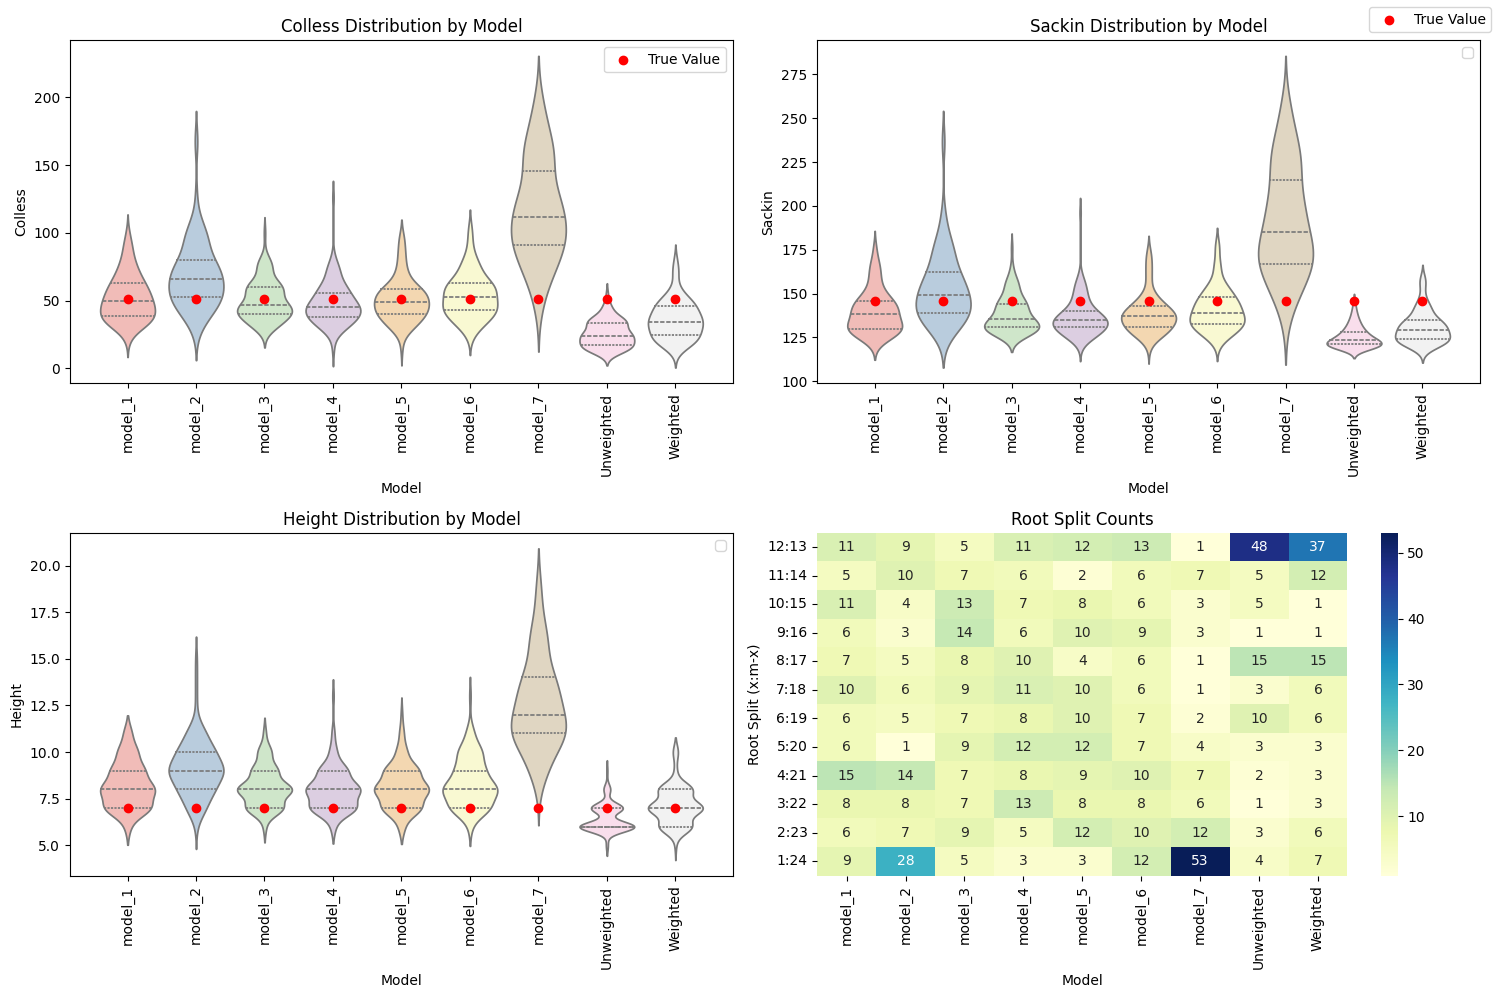

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------
# 1. Í∑∏Î¶¥ Î©îÌä∏Î¶≠ ÏÑ§Ï†ï
# -----------------------------
metrics = ["Colless", "Sackin", "Height"]
m = polytomy_size  # Ï†ÑÏ≤¥ leaf Ïàò

# Î™®Îç∏ ÏàúÏÑú: weighted, unweightedÏùÑ ÎßàÏßÄÎßâÏúºÎ°ú
model_order_raw = list(df_combined['Model'].unique())
special = ["Unweighted", "Weighted"]
model_order = [m for m in model_order_raw if m not in special] + special

# -----------------------------
# 2. Figure ÏÑ§Ï†ï (2x2)
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# -----------------------------
# 3. Violin plots
# -----------------------------
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.violinplot(
        x="Model",
        y=metric,
        data=df_combined,
        inner="quartile",
        palette="Pastel1",
        order=model_order,
        ax=ax
    )
    # Ï†ïÎãµ Ìä∏Î¶¨ Í∞í ÌëúÏãú
    ax.scatter(
        x=range(len(model_order)),
        y=[answer_stats[metric]]*len(model_order),
        color='red',
        zorder=10,
        label="True Value" if i == 0 else None
    )
    ax.set_title(f"{metric} Distribution by Model")
    ax.set_xticklabels(model_order, rotation=90)

    ax.legend()

# -----------------------------
# 4. Heatmap for Root Split
# -----------------------------
df_combined['X'] = df_combined['RootSplit'].astype(int)

# pivot table: Ìñâ=X, Ïó¥=Model (Î™®Îç∏ ÏàúÏÑú Î∞òÏòÅ)
heat_data = df_combined.pivot_table(
    index='X',
    columns='Model',
    aggfunc='size',
    fill_value=0
).reindex(columns=model_order)

# yÏ∂ïÏùÑ Îí§ÏßëÍ∏∞ (1Ïù¥ ÏïÑÎûòÏ™Ω)
heat_data = heat_data.sort_index(ascending=False)

ax = axes[1, 1]
sns.heatmap(
    heat_data,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    ax=ax
)

# yÏ∂ï tickÏùÑ x:(m-x) ÌòïÌÉúÎ°ú Î≥ÄÌôò
y_labels = [f"{x}:{m-x}" for x in heat_data.index]
ax.set_yticklabels(y_labels, rotation=0)

ax.set_title("Root Split Counts")
ax.set_xlabel("Model")
ax.set_ylabel("Root Split (x:m-x)")

# -----------------------------
# 5. Layout Ï†ïÎ¶¨
# -----------------------------
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()

### 2.6.2. 2D Statistics

#### 2.6.2.1. Calculation

##### 2.6.2.1.1. RF Distance

- Tree load
- 2D tree statistic Í≥ÑÏÇ∞

- RF distance, normalized RF distance Í≥ÑÏÇ∞
  - Original TreeÏùò topologyÏôÄ ÎπÑÍµê

In [28]:
from dendropy.calculate import treecompare

# Ï†ïÎãµ Ìä∏Î¶¨
answer_tree_path = "nwk/answer/polytomy_removed_tree.nwk"
answer_tree = dendropy.Tree.get(
    path=answer_tree_path,
    schema="newick",
    taxon_namespace=taxa,
    preserve_underscores=True
)
for e in answer_tree.postorder_edge_iter():
    e.length = None  # edge lengths Ï†úÍ±∞

# ÏÉàÎ°úÏö¥ Î¶¨Ïä§Ìä∏ Ï¥àÍ∏∞Ìôî
rf_distances_new = []
nrf_distances_new = []

# Unweighted
dists, n_dists = [], []
for t in trees_unweighted_dendropy:
    for e in t.postorder_edge_iter():
        e.length = None
    rf = treecompare.symmetric_difference(answer_tree, t)
    nrf = rf / (2 * (len(t.leaf_nodes()) - 3))
    dists.append(rf)
    n_dists.append(nrf)
rf_distances_new.append(dists)
nrf_distances_new.append(n_dists)

# Weighted
dists, n_dists = [], []
for t in trees_weighted_dendropy:
    for e in t.postorder_edge_iter():
        e.length = None
    rf = treecompare.symmetric_difference(answer_tree, t)
    nrf = rf / (2 * (len(t.leaf_nodes()) - 3))
    dists.append(rf)
    n_dists.append(nrf)
rf_distances_new.append(dists)
nrf_distances_new.append(n_dists)

##### 2.6.2.1.2. Quartet Distance

In [29]:
models_new_only = [
    "nwk/simulation/trees_unweighted.nwk",
    "nwk/simulation/trees_weighted.nwk"
]

- Quartet Distance Í≥ÑÏÇ∞ (Í∑∏ÎÉ•, normalized)

In [30]:
%%R -i answer_tree_path -i models_new_only -o qds_new -o nqds_new
library(ape)
library(Quartet)

answer_tree <- read.tree(answer_tree_path)

qds_new <- list()
nqds_new <- list()

for (i in seq_along(models_new_only)) {
  file_path <- models_new_only[[i]]
  tree_lines <- readLines(file_path)
  
  qd_vec <- numeric(length(tree_lines))
  nqd_vec <- numeric(length(tree_lines))
  
  for (j in seq_along(tree_lines)) {
    tr_text <- tree_lines[j]
    
    tmp_file <- tempfile(fileext = ".nwk")
    writeLines(tr_text, tmp_file)
    
    qd_val <- QuartetDistance(answer_tree_path, tmp_file)
    nqd_val <- qd_val / choose(length(read.tree(text=tr_text)$tip.label), 4)
    
    unlink(tmp_file)
    
    qd_vec[j] <- qd_val
    nqd_vec[j] <- nqd_val
  }
  
  qds_new[[i]] <- qd_vec
  nqds_new[[i]] <- nqd_vec
}

#### 2.6.2.2. Plot

- Îç∞Ïù¥ÌÑ∞ ÌÜµÌï©

In [31]:
rf_distances_all = rf_distances + rf_distances_new
nrf_distances_all = nrf_distances + nrf_distances_new
qds_all = qds + qds_new
nqds_all = nqds + nqds_new

- 2D statistic plot

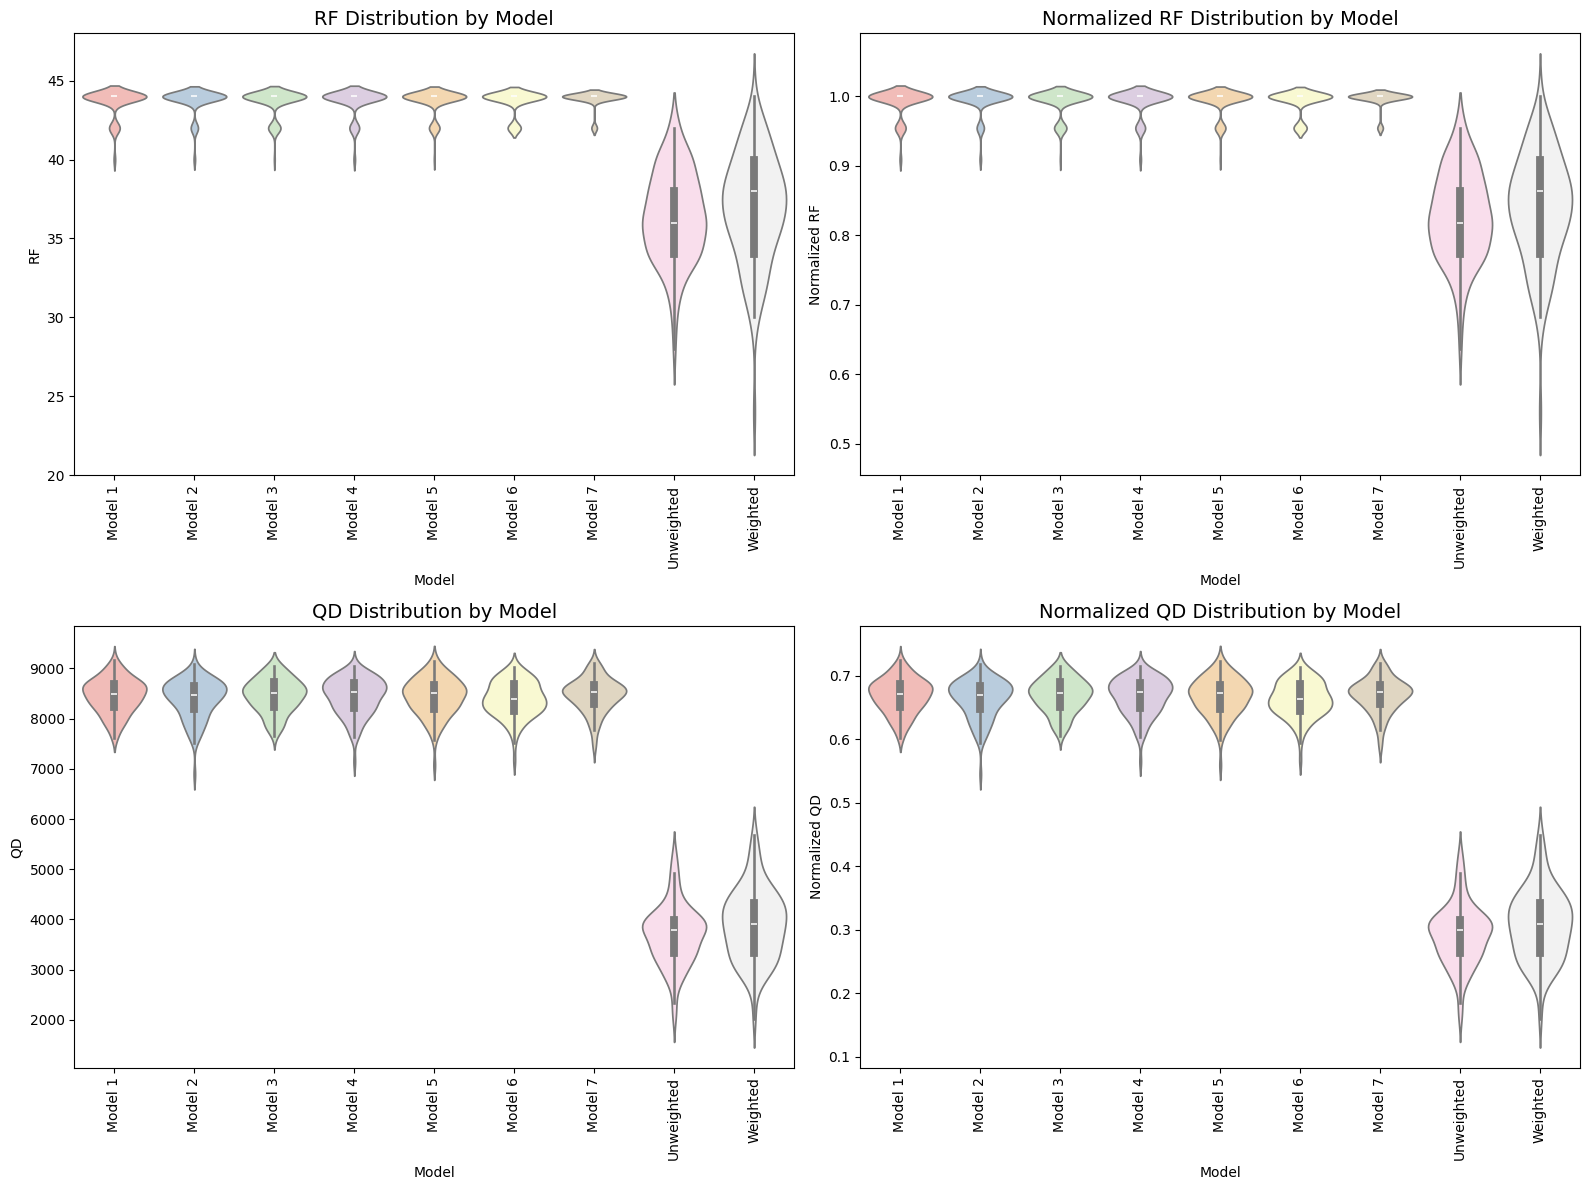

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Î™®Îç∏ Ïù¥Î¶Ñ
n_existing = len(models)
model_labels_all = [f"Model {i+1}" for i in range(n_existing)] + ["Unweighted", "Weighted"]

# long-form Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± Ìï®Ïàò
def make_long_df(data_list, model_labels, metric_name):
    df = pd.DataFrame({
        "Value": [v for model in data_list for v in model],
        "Model": [model_labels[i] for i, model in enumerate(data_list) for _ in model]
    })
    df["Metric"] = metric_name
    return df

# long-form Îç∞Ïù¥ÌÑ∞
df_rf = make_long_df(rf_distances_all, model_labels_all, "RF")
df_nrf = make_long_df(nrf_distances_all, model_labels_all, "Normalized RF")
df_qd = make_long_df(qds_all, model_labels_all, "QD")
df_nqd = make_long_df(nqds_all, model_labels_all, "Normalized QD")

df_all = pd.concat([df_rf, df_nrf, df_qd, df_nqd], ignore_index=True)

# -----------------------------
# 2x2 subplot Í∑∏Î¶¨Í∏∞
# -----------------------------
metrics = ["RF", "Normalized RF", "QD", "Normalized QD"]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    df_plot = df_all[df_all["Metric"] == metric]
    sns.violinplot(
        x="Model",
        y="Value",
        data=df_plot,
        inner="box",
        palette="Pastel1",
        order=model_labels_all,
        ax=ax
    )
    ax.set_title(f"{metric} Distribution by Model", fontsize=14)
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# üîö End of Notebook

# Kuhn 2011 Method Result

- Data: 
  - Title: A quantitative model of normal C. elegans embryogenesis and its disruption after stress
  - doi: https://doi.org/10.1016/j.ydbio.2012.11.034
    - Supplementary Table 1: List of all strains, embryos and conditions used for these analyses along with statistics about lineaging depth and developmental rate.

Method
- Read `NIHMS428096-supplement-03.xlsx` and apply to tree.
- Convert the names into `Zappaapppa...` form.
- Apply the branch length.
- Delete the descendants if the branch has zero length.

* AB, P1 time = 0 (Sulston 1983)

## 1. Draw Lengthed Tree

In [33]:
import pandas as pd

# ÏóëÏÖÄ ÌååÏùº ÏùΩÍ∏∞
file_path = "csv/NIHMS428096-supplement-03.xlsx"  # Ïã§Ï†ú ÌååÏùº Í≤ΩÎ°úÎ°ú Î∞îÍøîÏ£ºÏÑ∏Ïöî
df = pd.read_excel(file_path)

# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
print(df.columns)  # Ïª¨ÎüºÎ™Ö ÌôïÏù∏

Index(['Cell',
       'Mean division time (minutes at 22 degrees C).  Start times aligned to ABala division = 74' ',
       'Mean division time (minutes) - normalized to Sulston rate (20 degrees C)',
       'Mean cell cycle length (minutes) - normalized to Sulston rate (20 degrees C)',
       'Division Time Stdev (minutes at 20C)',
       'Cell Cycle Stdev (minutes at 20C)', 'Division Time CV',
       'Cell Cycle CV', '# of embryos in which division was observed',
       '# of embryos in which birth was observed',
       'Mean Movement rate (microns per minute)',
       'Mean movement distance (microns)'],
      dtype='object')


In [34]:
cell_time = df[['Cell', 'Mean division time (minutes) - normalized to Sulston rate (20 degrees C)',]]

# cell_time Ïó¥ Ïù¥Î¶Ñ Î≥ÄÍ≤Ω
cell_time = cell_time.rename(columns={
    'Cell': 'name',
    'Mean division time (minutes) - normalized to Sulston rate (20 degrees C)': 'time'
})

# ÌôïÏù∏
print(cell_time.columns)
print(cell_time.shape)

print(cell_time.columns)
print(cell_time.shape)

Index(['name', 'time'], dtype='object')
(1183, 2)
Index(['name', 'time'], dtype='object')
(1183, 2)


In [35]:
# cell_time Î≥µÏÇ¨
cell_time_new = cell_time.copy()

# mapping: ÏõêÎûò name ‚Üí Zap Ïù¥Î¶Ñ(Lineage Name)
mapping = dict(zip(z_only_df_unique['Cell'], z_only_df_unique['Lineage Name']))

# Ïù¥Î¶Ñ ÏπòÌôò
cell_time_new['name'] = cell_time_new['name'].map(mapping).fillna(cell_time_new['name'])

# Ï§ëÎ≥µÎêú Ïù¥Î¶Ñ Ï†úÍ±∞(ÏõêÌïòÏãúÎ©¥ Í≥†Ïú†Ìôî ÏóÜÏù¥ ÏÇ≠Ï†ú)
cell_time_new = cell_time_new[~cell_time_new['name'].duplicated(keep=False)]

# division time NaN Ï†úÍ±∞
cell_time_new = cell_time_new.dropna(subset=['time'])

In [36]:
import pandas as pd
import re

# ÏòàÏãú: cell_time['name'] ÏÇ¨Ïö©
# cell_time = pd.DataFrame({'name': ['ABa','ABp','EMS','P2','ABal','ABar','ABpl','ABpr','Zpaa','Zpap'],
#                           'time': [42,42,45,47,55,55,55,55,61,62]})

# 1. Í∞Å Cell(name)ÏóêÏÑú ÏÜåÎ¨∏Ïûê ÏïÑÎãå Î∂ÄÎ∂ÑÎßå Ï∂îÏ∂ú
cell_prefixes = cell_time['name'].apply(lambda x: ''.join(re.findall(r'[^a-z]', x)))

# 2. Îì±Ïû• ÌöüÏàò Í≥ÑÏÇ∞
counts = cell_prefixes.value_counts()

# 3. 1Î≤à Ïù¥ÏÉÅ Îì±Ïû•ÌïòÎäî Í∞í ÏÑ†ÌÉù (Zap Î≥ÄÌôò ÎåÄÏÉÅ prefix)
at_least_once_prefixes = counts[counts >= 1].index.tolist()

# ÌôïÏù∏
print(at_least_once_prefixes)

['AB', 'MS', 'C', 'E', 'D', 'EMS', 'P2', 'P3', 'P4', 'Z2', 'Z3']


In [37]:
for cell in at_least_once_prefixes:
    # z_only_df_uniqueÏóêÏÑú CellÏù¥ ÏùºÏπòÌïòÎäî Ìñâ Ï∞æÍ∏∞
    match = z_only_df_unique[z_only_df_unique['Cell'] == cell]
    if not match.empty:
        lineage = match['Lineage Name'].values[0]
    else:
        lineage = ""  # ÏóÜÏúºÎ©¥ Îπà Î¨∏ÏûêÏó¥
    print(f"Cell: {cell}, Lineage: {lineage}")

Cell: AB, Lineage: Za
Cell: MS, Lineage: Zpaa
Cell: C, Lineage: Zppa
Cell: E, Lineage: Zpap
Cell: D, Lineage: Zpppa
Cell: EMS, Lineage: Zpa
Cell: P2, Lineage: Zpp
Cell: P3, Lineage: Zppp
Cell: P4, Lineage: Zpppp
Cell: Z2, Lineage: Zppppp
Cell: Z3, Lineage: Zppppa


In [56]:
import pandas as pd
import re

# 1Ô∏è‚É£ cell_time Î∂àÎü¨Ïò§Í∏∞ ÎòêÎäî Í∏∞Ï°¥ DataFrame ÏÇ¨Ïö©
# cell_time = pd.read_excel("your_file.xlsx")
# Ïó¥ Ïù¥Î¶ÑÏùÄ 'name', 'time'ÏúºÎ°ú Ï†ïÎ¶¨ÎêòÏñ¥ ÏûàÎã§Í≥† Í∞ÄÏ†ï

# 2Ô∏è‚É£ mapping Ï§ÄÎπÑ: ÏõêÎûò Cell prefix ‚Üí Zap Ïù¥Î¶Ñ(Lineage Name)
# z_only_df_uniqueÎäî preprocessing ÌõÑ CSVÏóêÏÑú Î∂àÎü¨Ïò® DataFrame
# z_only_df_unique = pd.read_csv("csv/Complete_cell_list_preprocessed.csv")
# Ïó¨Í∏∞ÏÑú 'Cell'Ïù¥ ÏõêÎûò prefix, 'Lineage Name'Ïù¥ Zap Ïù¥Î¶Ñ

mapping = dict(zip(z_only_df_unique['Cell'], z_only_df_unique['Lineage Name']))

# 3Ô∏è‚É£ Ïù¥Î¶Ñ Î≥ÄÌôò Ìï®Ïàò: prefixÍ∞Ä mappingÏóê ÏûàÏúºÎ©¥ ÍµêÏ≤¥
def convert_cell_name(cell_name):
    # CellÏóêÏÑú ÏÜåÎ¨∏Ïûê ÏïÑÎãå prefix Ï∂îÏ∂ú
    prefix_match = re.match(r'[^a-z]+', cell_name)
    if prefix_match:
        prefix = prefix_match.group()
        rest = cell_name[len(prefix):]  # ÎÇòÎ®∏ÏßÄ ÏÜåÎ¨∏Ïûê Î∂ÄÎ∂Ñ
        if prefix in mapping:
            return mapping[prefix] + rest.lower()
    return cell_name

# 4Ô∏è‚É£ Î≥ÄÌôò Ï†ÅÏö©
cell_time['name'] = cell_time['name'].apply(convert_cell_name)

# 5Ô∏è‚É£ Ï§ëÎ≥µÎêú Ïù¥Î¶Ñ ÏÇ≠Ï†ú (Í≥†Ïú†Ìôî ÏóÜÏù¥)
cell_time = cell_time[~cell_time['name'].duplicated(keep=False)]

# 6Ô∏è‚É£ division time NaN ÏÇ≠Ï†ú
cell_time = cell_time.dropna(subset=['time'])

# Z Î£®Ìä∏ Ï∂îÍ∞Ä (division time 0) #AB = Za, P1 = Zp
cell_time = pd.concat([pd.DataFrame([{'name': 'Z', 'time': 1}]), cell_time], ignore_index=True)
cell_time = pd.concat([pd.DataFrame([{'name': 'Za', 'time': 2}]), cell_time], ignore_index=True)
cell_time = pd.concat([pd.DataFrame([{'name': 'Zp', 'time': 2}]), cell_time], ignore_index=True)

# CSVÎ°ú Ï†ÄÏû•
output_path = "csv/cell_time_processed.csv"
cell_time.to_csv(output_path, index=False)

In [57]:
import pandas as pd

# 1Ô∏è‚É£ cell_time CSV Î∂àÎü¨Ïò§Í∏∞
cell_time = pd.read_csv("csv/cell_time_processed.csv")  # 'name', 'time'
valid_cells = set(cell_time['name'])

# 2Ô∏è‚É£ edge CSV Î∂àÎü¨Ïò§Í∏∞
edges_df = pd.read_csv("csv/edges_list_all.csv")  # 'from','to'

# 3Ô∏è‚É£ cell_timeÏóê ÏûàÎäî ÎÖ∏ÎìúÎßå ÌïÑÌÑ∞ÎßÅ
filtered_edges = edges_df[
    edges_df['from'].isin(valid_cells) & edges_df['to'].isin(valid_cells)
].copy()

# ÌïÑÌÑ∞ÎßÅÎêú edge Ï†ÄÏû•
filtered_edges_output_path = "csv/edges_filtered.csv"
filtered_edges.to_csv(filtered_edges_output_path, index=False)
print(f"ÌïÑÌÑ∞ÎßÅÎêú edgeÎ•º '{filtered_edges_output_path}'Ïóê Ï†ÄÏû•ÌñàÏäµÎãàÎã§.")

print(f"ÏõêÎ≥∏ edge Ïàò: {len(edges_df)}")
print(f"ÌïÑÌÑ∞ÎßÅ ÌõÑ edge Ïàò: {len(filtered_edges)}")
print("ÌïÑÌÑ∞ÎßÅÎêú edge ÏòàÏãú:")
print(filtered_edges.head())

# 4Ô∏è‚É£ ÌïÑÌÑ∞ÎßÅ ÌõÑ ÎÇ®ÏùÄ ÎÖ∏Îìú ÌôïÏù∏
filtered_nodes = set(filtered_edges['from']).union(set(filtered_edges['to']))
print(f"ÌïÑÌÑ∞ÎßÅ ÌõÑ ÎÇ®ÏùÄ ÎÖ∏Îìú Ïàò: {len(filtered_nodes)}")
print("ÎÖ∏Îìú ÏòàÏãú:", list(filtered_nodes)[:10])

# 5Ô∏è‚É£ root 'Z'Í∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏
if 'Z' in filtered_nodes:
    print("Î£®Ìä∏ ZÍ∞Ä Ï°¥Ïû¨Ìï©ÎãàÎã§.")
else:
    print("Î£®Ìä∏ ZÍ∞Ä ÌïÑÌÑ∞ÎßÅÏóêÏÑú Ï†úÍ±∞ÎêòÏóàÏäµÎãàÎã§. Newick ÏÉùÏÑ± Î∂àÍ∞Ä!")

ÌïÑÌÑ∞ÎßÅÎêú edgeÎ•º 'csv/edges_filtered.csv'Ïóê Ï†ÄÏû•ÌñàÏäµÎãàÎã§.
ÏõêÎ≥∏ edge Ïàò: 2345
ÌïÑÌÑ∞ÎßÅ ÌõÑ edge Ïàò: 609
ÌïÑÌÑ∞ÎßÅÎêú edge ÏòàÏãú:
    from      to
0      Z      Za
1     Za     Zap
2    Zap    Zapl
3   Zapl   Zapla
4  Zapla  Zaplap
ÌïÑÌÑ∞ÎßÅ ÌõÑ ÎÇ®ÏùÄ ÎÖ∏Îìú Ïàò: 610
ÎÖ∏Îìú ÏòàÏãú: ['Zaprappp', 'Zapra', 'Zaplpapap', 'Zaarapaap', 'Zaarpaaaap', 'Zaalpap', 'Zaaraaaaap', 'Zpaapapapp', 'Zaalaappa', 'Zpaaaaaapa']
Î£®Ìä∏ ZÍ∞Ä Ï°¥Ïû¨Ìï©ÎãàÎã§.


In [58]:
import pandas as pd
from collections import defaultdict

# 1Ô∏è‚É£ cell_time Î∂àÎü¨Ïò§Í∏∞
cell_time = pd.read_csv("csv/cell_time_processed.csv")  # 'name','time'
time_dict = dict(zip(cell_time['name'], cell_time['time']))

# 2Ô∏è‚É£ ÌïÑÌÑ∞ÎßÅÎêú edge Î∂àÎü¨Ïò§Í∏∞
edges_df = pd.read_csv("csv/edges_filtered.csv")  # 'from','to'

# 3Ô∏è‚É£ Z -> Za, Z -> Zp edge Ï∂îÍ∞Ä
edges_df = pd.concat([
    edges_df,
    pd.DataFrame([{'from': 'Z', 'to': 'Za'}, {'from': 'Z', 'to': 'Zp'}])
], ignore_index=True)

# 4Ô∏è‚É£ Ï§ëÎ≥µ Ï†úÍ±∞
edges_df = edges_df.drop_duplicates(subset=['from','to']).reset_index(drop=True)

# 5Ô∏è‚É£ Î™®Îì† edgeÏóê length Í≥ÑÏÇ∞
def compute_length(row):
    try:
        if row['from'] == 'Z':  # Î£®Ìä∏ Î∞îÎ°ú ÏïÑÎûò edgeÎäî 0
            return 0.0
        return float(time_dict[row['to']] - time_dict[row['from']])
    except KeyError:
        print(f"Warning: {row['from']} or {row['to']} not in cell_time")
        return 0.0

edges_df['length'] = edges_df.apply(compute_length, axis=1)

# 6Ô∏è‚É£ Ìä∏Î¶¨ ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±
tree_dict = defaultdict(list)
for _, row in edges_df.iterrows():
    tree_dict[row['from']].append((row['to'], row['length']))

# 7Ô∏è‚É£ Ïû¨Í∑ÄÏ†ÅÏúºÎ°ú Newick ÏÉùÏÑ± (branch length Ìè¨Ìï®)
def build_newick_with_length(node):
    if node not in tree_dict or len(tree_dict[node]) == 0:
        return node
    children_newick = [
        f"{build_newick_with_length(child)}:{length:.2f}" 
        for child, length in tree_dict[node]
    ]
    return "(" + ",".join(children_newick) + ")" + node

# 8Ô∏è‚É£ Î£®Ìä∏Î∂ÄÌÑ∞ Newick ÏÉùÏÑ±
root = 'Z'
newick_str = build_newick_with_length(root) + ";"
print(newick_str)

# 9Ô∏è‚É£ ÌååÏùº Ï†ÄÏû•
newick_path = "nwk/tree_filtered_with_length.nwk"
with open(newick_path, "w") as f:
    f.write(newick_str)

(((((((((Zaplapaaaa:80.00,Zaplapaaap:77.00)Zaplapaaa:50.00,Zaplapaap:54.00)Zaplapaa:40.00,((Zaplapappp:89.00)Zaplapapp:48.00,Zaplapapa:51.00)Zaplapap:36.00)Zaplapa:30.00,(((Zaplapppap:71.00,Zaplapppaa:97.00)Zaplapppa:56.00,Zaplapppp:55.00)Zaplappp:41.00,(Zaplappaa:51.00,Zaplappap:51.00)Zaplappa:38.00)Zaplapp:31.00)Zaplap:28.00,((((Zaplaapapp:65.00,Zaplaapapa:88.00)Zaplaapap:49.00,(Zaplaapaap:73.00,Zaplaapaaa:85.00)Zaplaapaa:51.00)Zaplaapa:39.00,(Zaplaappa:54.00,Zaplaappp:47.00)Zaplaapp:35.00)Zaplaap:31.00,(((Zaplaaaaaa:93.00,Zaplaaaaap:64.00)Zaplaaaaa:53.00,Zaplaaaap:51.00)Zaplaaaa:38.00,(Zaplaaapp:50.00,Zaplaaapa:57.00)Zaplaaap:39.00)Zaplaaa:32.00)Zaplaa:27.00)Zapla:18.00,(((((Zaplppaapp:79.00,Zaplppaapa:86.00)Zaplppaap:52.00,(Zaplppaaaa:62.00)Zaplppaaa:56.00)Zaplppaa:43.00,((Zaplppapap:89.00,Zaplppapaa:70.00)Zaplppapa:51.00,(Zaplppappa:79.00,Zaplppappp:90.00)Zaplppapp:55.00)Zaplppap:40.00)Zaplppa:32.00,(((Zaplpppaaa:81.00,Zaplpppaap:77.00)Zaplpppaa:50.00,(Zaplpppapa:55.00)Zaplpppap:5

In [59]:
from Bio import Phylo

# Newick ÏùΩÍ∏∞
tree = Phylo.read("nwk/tree_filtered_with_length.nwk", "newick")

# Î™®Îì† ÎÖ∏Îìú(flatten)
all_nodes = list(tree.get_terminals()) + list(tree.get_nonterminals())

# Ïù¥Î¶Ñ Îß§Ìïë
for i, node in enumerate(all_nodes, start=1):
    node.name = f"t_{i}"

# Ï†ÄÏû•
Phylo.write(tree, "tree_filtered_with_length_all_ti.nwk", "newick")

1

In [60]:
 
def calc_node_heights(clade, current_height=0, heights=None):
    if heights is None:
        heights = {}
    heights[clade] = current_height
    for child in clade.clades:
        branch_len = child.branch_length if child.branch_length else 0
        calc_node_heights(child, current_height + branch_len, heights)
    return heights

heights = calc_node_heights(tree.root)

# 3. Í≤∞Í≥º ÌôïÏù∏
for node, h in heights.items():
    name = node.name if node.name else "internal"
    # print(f"{name}: {h}")

# 4. root height ÌôïÏù∏
root_height = max(heights.values())
print("Root height:", root_height)

Root height: 362.0


## 2. Parameter Estimation by BEAST
- $\lambda - \mu$
- $\mu / \lambda$

### 2.1. `R` file 1

cat('\t\t<scaleOperator scaleFactor="0.75" weight="3">\n')
cat('\t\t\t<parameter idref="birthDeath.meanGrowthRate"/>\n')
cat('\t\t</scaleOperator>\n')
cat('\t\t<scaleOperator scaleFactor="0.75" weight="3">\n')
cat('\t\t\t<parameter idref="birthDeath.relativeDeathRate"/>\n')
cat('\t\t</scaleOperator>\n')

converts to the below

cat('\t\t<randomWalkOperator windowSize="0.1" weight="3">\n')
cat('\t\t\t<parameter idref="birthDeath.relativeDeathRate"/>\n')
cat('\t\t</randomWalkOperator>\n')
cat('\t\t<randomWalkOperator windowSize="0.1" weight="3">\n')
cat('\t\t\t<parameter idref="birthDeath.meanGrowthRate"/>\n')
cat('\t\t</randomWalkOperator>\n')

cat('\t<!-- Node Age Priors                                                         -->\n')
for (i in 1:length(clade.list)) {
		group <- paste("group", i, sep = "")
		cat("\t\t\t\t",'<uniformPrior lower=','"',branching.times(phy)[i]-error,'"',' upper=','"',branching.times(phy)[i]+error,'"','>',"\n",sep="")
		cat("\t\t\t\t\t",'<tmrcaStatistic idref=','"','tmrca(',group,')','"','/>',"\n",sep="")
		cat("\t\t\t\t",'</uniformPrior>',"\n",sep="")
	}

converts to the below

for (i in 1:length(clade.list)) {
    group <- paste("group", i, sep = "")
    # ÏùåÏàò Î≤îÏúÑ Î∞©ÏßÄ
    lower <- 0
    upper <- 400 # tree depth = 362Ï†ïÎèÑÎùºÏÑú
    cat("\t\t\t\t", '<uniformPrior lower="', lower, '" upper="', upper, '">', "\n", sep="")
    cat("\t\t\t\t\t", '<tmrcaStatistic idref="', 'tmrca(', group, ')"', '/>', "\n", sep="")
    cat("\t\t\t\t", '</uniformPrior>', "\n", sep="")
}

In [63]:
%%R
library(ape)


all.clades <- function(phy) {

	foo <- function (x, phy, tip.labels = TRUE) 
			{
			if (class(phy) != "phylo") 
			stop("Phylogeny required")
			if (!(x %in% as.numeric(phy$edge))) 
			stop("Node not in range for phylogeny")

			while (any(x > min(phy$edge[,1])-1)) {

			maxx.loc <- which(x == max(x))
			maxx <- x[maxx.loc]
			x <- x[-maxx.loc]
			newx <- as.numeric(phy$edge[, 2][which(phy$edge[, 1] == maxx)])
			x <- c(x, newx)
			}

	x <- unique(x)
	if (tip.labels) {return(phy$tip.label[x])} else {return(x)}
	}


    nodes <- sort(unique(as.numeric(phy$edge)))
    nodes <- nodes[nodes > min(phy$edge[,1])-1]
    clade.list <- lapply(nodes, foo, phy=phy)
    
    return(clade.list)
    }

PolytomyResolver <- function(phy, error=0.001, file.out="") {

sink(paste(file.out, ".xml", sep=""))

    clade.list <- all.clades(phy)
    group <- paste("group", 1:length(clade.list), sep = "")

cat('<?xml version="1.0" standalone="yes"?>\n')
cat("<!-- Generated by Polytomy Resolver v1.0                             -->\n")
cat("<!--   by Tyler Kuhn, Gavin Thomas and Arne Mooers                   -->\n")
cat("<!--                                                                 -->\n")
cat("<!--   For resolving polytomous nodes in a dated tree                -->\n")
cat("<!--    under a Birth-Death model                                    -->\n")
cat("<beast>","\n")
cat("\t<!-- The list of taxa analyse (can also include dates/ages).                 -->\n")
cat("\t<!-- ntax=",length(clade.list[[1]]),"                                                                 -->\n",sep="")
cat('\t<taxa id="taxa">\n')
for (j in 1:length(clade.list[[1]])) {
		cat("\t\t",'<taxon id="',clade.list[[1]][j],'"','/>',"\n", sep="")
	}
cat("\t",'</taxa>',"\n", sep="")

cat("\n")
cat('<!-- Constraints - Begin monophyly constraints -->\n')
cat("\n")
	
for (i in 1:length(clade.list)) {
        group <- paste("group", i, sep = "")
        taxa <- clade.list[[i]]
        cat("\t",'<taxa id=','"',group,'"','>',"\n",sep="")
		for (j in 1:length(clade.list[[i]])) {
    		cat("\t\t",'<taxon idref=','"',clade.list[[i]][j],'"','/>',"\n", sep="")
    	}
		cat("\t",'</taxa>',"\n", sep="")
    }
	
cat("\n")
cat('<!-- Constraints - End monophyly constraints -->\n')
cat("\n")
	
cat('\t<alignment id="alignment" dataType="nucleotide">\n')
for (i in 1:length(phy$tip.label)) {
		cat("\t\t<sequence>\n")
		cat("\t\t\t",'<taxon idref="',phy$tip.label[i],'"/>',"\n",sep="")
		cat("\t\t\tN\n")
		cat("\t\t</sequence>\n")
	}
cat("\t</alignment>\n")
cat("\t<!-- The unique patterns from 1 to end                                       -->\n")
cat("\t<!-- npatterns=0                                                             -->\n")
cat('\t<patterns id="patterns" from="1">\n')
cat('\t\t<alignment idref="alignment"/>\n')
cat("\t</patterns>\n")
cat("\t<!-- A prior on the distribution node heights defined given                  -->\n")
cat("\t<!-- a Birth-Death speciation process (Gernhard 2008).                       -->\n")
cat('\t<birthDeathModel id="birthDeath" units="substitutions">\n')
cat("\t\t<birthMinusDeathRate>\n")
cat('\t\t\t<parameter id="birthDeath.meanGrowthRate" value="1.0" lower="0.0" upper="Infinity"/>\n')
cat("\t</birthMinusDeathRate>\n")
cat("\t\t<relativeDeathRate>\n")
cat('\t\t\t<parameter id="birthDeath.relativeDeathRate" value="0.5" lower="0.0" upper="Infinity"/>\n')
cat("\t\t</relativeDeathRate>\n")
cat("\t</birthDeathModel>\n")
cat("\t<!-- This is a simple constant population size coalescent model              -->\n")
cat("\t<!-- that is used to generate an initial tree for the chain.                 -->\n")
cat('\t<constantSize id="initialDemo" units="substitutions">\n')
cat("\t\t<populationSize>\n")
cat('\t\t\t<parameter id="initialDemo.popSize" value="100.0"/>\n')
cat("\t\t</populationSize>\n")
cat("\t\t</constantSize>\n")
	
cat("\n")
cat('<!-- Constraints - Begin Start Tree -->\n')
cat("\n")
cat('\t<!-- The starting tree.                                                      -->\n')
cat('\t<newick id="startingTree">\n')
cat("\t\t",write.tree(phy),"\n",sep="")
cat('\t</newick>\n')
	
cat("\n")
cat('<!-- Constraints - End Start Tree -->\n')
cat("\n")
	
cat('\t<!-- Generate a tree model                                                   -->\n')
cat('\t<treeModel id="treeModel">\n')
cat('\t\t<coalescentTree idref="startingTree"/>\n')
cat('\t\t<rootHeight>\n')
cat('\t\t\t<parameter id="treeModel.rootHeight"/>\n')
cat('\t\t</rootHeight>\n')
cat('\t\t<nodeHeights internalNodes="true">\n')
cat('\t\t\t<parameter id="treeModel.internalNodeHeights"/>\n')
cat('\t\t</nodeHeights>\n')
cat('\t\t<nodeHeights internalNodes="true" rootNode="true">\n')
cat('\t\t\t<parameter id="treeModel.allInternalNodeHeights"/>\n')
cat('\t\t</nodeHeights>\n')
cat('\t</treeModel>\n')
cat('\t<!-- Generate a speciation likelihood for Yule or Birth Death                -->\n')
cat('\t<speciationLikelihood id="speciation">\n')
cat('\t\t<model>\n')
cat('\t\t\t<birthDeathModel idref="birthDeath"/>\n')
cat('\t\t</model>\n')
cat('\t\t<speciesTree>\n')
cat('\t\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t</speciesTree>\n')
cat('\t</speciationLikelihood>\n')
cat('\t<!-- The strict clock (Uniform rates across branches)                        -->\n')
cat('\t<strictClockBranchRates id="branchRates">\n')
cat('\t\t<rate>\n')
cat('\t\t\t<parameter id="clock.rate" value="1.0"/>\n')
cat('\t\t</rate>\n')
cat('\t</strictClockBranchRates>\n')
cat('\t<!-- The HKY substitution model (Hasegawa, Kishino & Yano, 1985)             -->\n')
cat('\t<HKYModel id="hky">\n')
cat('\t\t<frequencies>\n')
cat('\t\t\t<frequencyModel dataType="nucleotide">\n')
cat('\t\t\t\t<frequencies>\n')
cat('\t\t\t\t\t<parameter id="frequencies" value="0.25 0.25 0.25 0.25"/>\n')
cat('\t\t\t\t</frequencies>\n')
cat('\t\t\t</frequencyModel>\n')
cat('\t\t</frequencies>\n')
cat('\t\t<kappa>\n')
cat('\t\t\t<parameter id="kappa" value="1.0" lower="0.0" upper="Infinity"/>\n')
cat('\t\t</kappa>\n')
cat('\t</HKYModel>\n')
cat('\t<!-- site model                                                              -->\n')
cat('\t<siteModel id="siteModel">\n')
cat('\t\t<substitutionModel>\n')
cat('\t\t\t<HKYModel idref="hky"/>\n')
cat('\t\t</substitutionModel>\n')
cat('\t</siteModel>\n')
cat('\t<treeLikelihood id="treeLikelihood" useAmbiguities="false">\n')
cat('\t\t<patterns idref="patterns"/>\n')
cat('\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t<siteModel idref="siteModel"/>\n')
cat('\t\t<strictClockBranchRates idref="branchRates"/>\n')
cat('\t</treeLikelihood>\n')

cat("\n")
cat('\t<!-- Constraints - Begin Monophyly statistics -->\n')
cat("\n")
	for (i in 1:length(clade.list)) {
		group <- paste("group", i, sep = "")
		cat("\t",'<tmrcaStatistic id=','"','tmrca(',group,')','"','>',"\n", sep="")
		cat("\t\t",'<mrca>\n', sep="")
		cat("\t\t\t",'<taxa idref=','"',group,'"','/>',"\n", sep="")
		cat("\t\t",'</mrca>\n', sep="")
		cat("\t\t",'<treeModel idref=','"','treeModel','"','/>',"\n", sep="")
		cat("\t",'</tmrcaStatistic>\n', sep="")
		cat("\t",'<monophylyStatistic id=','"','monophyly(',group,')','"','>',"\n", sep="")
		cat("\t\t",'<mrca>\n', sep="")
		cat("\t\t\t",'<taxa idref=','"',group,'"','/>',"\n", sep="")
		cat("\t\t",'</mrca>\n', sep="")
		cat("\t\t",'<treeModel idref=','"','treeModel','"','/>',"\n", sep="")
		cat("\t",'</monophylyStatistic>\n', sep="")	}
cat("\n")
cat('\t<!-- Constraints - End Monophyly statistics -->\n')
cat("\n")	

cat('\t<!-- Define operators                                                        -->\n')
cat('\t<operators id="operators">\n')
cat('\t\t<subtreeSlide size="100.0" gaussian="true" weight="15">\n')
cat('\t\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t</subtreeSlide>\n')
cat('\t\t<narrowExchange weight="15">\n')
cat('\t\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t</narrowExchange>\n')
cat('\t\t<wideExchange weight="3">\n')
cat('\t\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t</wideExchange>\n')
cat('\t\t<wilsonBalding weight="3">\n')
cat('\t\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t</wilsonBalding>\n')
cat('\t\t<scaleOperator scaleFactor="0.75" weight="3">\n')
cat('\t\t\t<parameter idref="treeModel.rootHeight"/>\n')
cat('\t\t</scaleOperator>\n')
cat('\t\t<uniformOperator weight="30">\n')
cat('\t\t\t<parameter idref="treeModel.internalNodeHeights"/>\n')
cat('\t\t</uniformOperator>\n')

#cat('\t\t<scaleOperator scaleFactor="0.75" weight="3">\n')
#cat('\t\t\t<parameter idref="birthDeath.meanGrowthRate"/>\n')
#cat('\t\t</scaleOperator>\n')
#cat('\t\t<scaleOperator scaleFactor="0.75" weight="3">\n')
#cat('\t\t\t<parameter idref="birthDeath.relativeDeathRate"/>\n')
#cat('\t\t</scaleOperator>\n')
# converts to the below
cat('\t\t<randomWalkOperator windowSize="0.1" weight="3">\n')
cat('\t\t\t<parameter idref="birthDeath.relativeDeathRate"/>\n')
cat('\t\t</randomWalkOperator>\n')

cat('\t\t<randomWalkOperator windowSize="0.1" weight="3">\n')
cat('\t\t\t<parameter idref="birthDeath.meanGrowthRate"/>\n')
cat('\t\t</randomWalkOperator>\n')

cat('\t\t<upDownOperator scaleFactor="0.75" weight="3">\n')
cat('\t\t\t<up>\n')
cat('\t\t\t</up>\n')
cat('\t\t\t<down>\n')
cat('\t\t\t\t<parameter idref="treeModel.allInternalNodeHeights"/>\n')
cat('\t\t\t</down>\n')
cat('\t\t</upDownOperator>\n')
cat('\t\t</operators>\n')
cat('\t<!-- Define MCMC                                                             -->\n')
cat('\t<mcmc id="mcmc" chainLength="11111000" autoOptimize="true">\n')
cat('\t\t<posterior id="posterior">\n')
cat('\t\t\t<prior id="prior">\n')
cat('\t\t\t\t<gammaPrior shape="0.05" scale="40.0" offset="0.0">\n')
cat('\t\t\t\t\t<parameter idref="kappa"/>\n')
cat('\t\t\t\t</gammaPrior>\n')
cat('\t\t\t\t<speciationLikelihood idref="speciation"/>\n')

cat("\n")
cat('\t<!-- Constraints - Begin Boolean Likelihood -->\n')
cat("\n")
	
cat("\t\t\t\t",'<booleanLikelihood>\n', sep="")
for (i in 1:length(clade.list)) {
		group <- paste("group", i, sep = "")
		cat("\t\t\t\t\t",'<monophylyStatistic idref=','"','monophyly(',group,')','"','/>',"\n", sep="")
    }
cat("\t\t\t\t",'</booleanLikelihood>\n', sep="")


# cat('\t<!-- Node Age Priors                                                         -->\n')
# for (i in 1:length(clade.list)) {
# 		group <- paste("group", i, sep = "")
# 		cat("\t\t\t\t",'<uniformPrior lower=','"',branching.times(phy)[i]-error,'"',' upper=','"',branching.times(phy)[i]+error,'"','>',"\n",sep="")
# 		cat("\t\t\t\t\t",'<tmrcaStatistic idref=','"','tmrca(',group,')','"','/>',"\n",sep="")
# 		cat("\t\t\t\t",'</uniformPrior>',"\n",sep="")
# 	}

# Node Age Priors (Safe version)
for (i in 1:length(clade.list)) {
    group <- paste("group", i, sep = "")
    # ÏùåÏàò Î≤îÏúÑ Î∞©ÏßÄ
    lower <- 0
    upper <- 400
    cat("\t\t\t\t", '<uniformPrior lower="', lower, '" upper="', upper, '">', "\n", sep="")
    cat("\t\t\t\t\t", '<tmrcaStatistic idref="', 'tmrca(', group, ')"', '/>', "\n", sep="")
    cat("\t\t\t\t", '</uniformPrior>', "\n", sep="")
}


	
cat("\n")
cat('\t<!-- Constraints - End Boolean Likelihood -->\n')
cat("\n")
	
cat('\t\t\t</prior>\n')
cat('\t\t\t<likelihood id="likelihood">\n')
cat('\t\t\t\t<treeLikelihood idref="treeLikelihood"/>\n')
cat('\t\t\t</likelihood>\n')
cat('\t\t</posterior>\n')
cat('\t\t<operators idref="operators"/>\n')
cat('\t\t<!-- write log to screen                                                     -->\n')
cat('\t\t<log id="screenLog" logEvery="1000">\n')
cat('\t\t\t<column label="Posterior" dp="4" width="12">\n')
cat('\t\t\t\t<posterior idref="posterior"/>\n')
cat('\t\t\t</column>\n')
cat('\t\t\t<column label="Prior" dp="4" width="12">\n')
cat('\t\t\t\t<prior idref="prior"/>\n')
cat('\t\t\t</column>\n')
cat('\t\t\t<column label="Likelihood" dp="4" width="12">\n')
cat('\t\t\t\t<likelihood idref="likelihood"/>\n')
cat('\t\t\t</column>\n')
cat('\t\t\t<column label="rootHeight" sf="6" width="12">\n')
cat('\t\t\t\t<parameter idref="treeModel.rootHeight"/>\n')
cat('\t\t\t</column>\n')
cat('\t\t\t<column label="clock.rate" sf="6" width="12">\n')
cat('\t\t\t\t<parameter idref="clock.rate"/>\n')
cat('\t\t\t</column>\n')
cat('\t\t</log>\n')
	
cat('\t\t<log id="fileLog" logEvery="1000" fileName="',file.out,'.log">\n',sep="")
cat('\t\t\t<posterior idref="posterior"/>\n')
cat('\t\t\t<prior idref="prior"/>\n')
cat('\t\t\t<likelihood idref="likelihood"/>\n')
cat('\t\t\t<parameter idref="treeModel.rootHeight"/>\n')
cat('\t\t\t<parameter idref="birthDeath.meanGrowthRate"/>\n')
cat('\t\t\t<parameter idref="birthDeath.relativeDeathRate"/>\n')
cat('\t\t\t<parameter idref="kappa"/>\n')
cat('\t\t\t<parameter idref="frequencies"/>\n')
cat('\t\t\t<parameter idref="clock.rate"/>\n')
cat('\t\t\t<treeLikelihood idref="treeLikelihood"/>\n')
cat('\t\t\t<speciationLikelihood idref="speciation"/>\n')
cat('\t\t</log>\n')
cat('\t\t<!-- write tree log to file                                                  -->\n')
cat('\t\t<logTree id="treeFileLog" logEvery="1000" nexusFormat="true" fileName="',file.out,'.trees" sortTranslationTable="true">\n',sep="")
cat('\t\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t\t<strictClockBranchRates idref="branchRates"/>\n')
cat('\t\t\t<posterior idref="posterior"/>\n')
cat('\t\t</logTree>\n')
cat('\t</mcmc>\n')
cat('\t<report>\n')
cat('\t\t<property name="timer">\n')
cat('\t\t\t<mcmc idref="mcmc"/>\n')
cat('\t\t</property>\n')
cat('\t</report>\n')
cat('</beast>\n')

sink()



sink(paste(file.out, ".nex", sep=""))
cat("#NEXUS\n")
cat("\n")
cat("Begin DATA;\n")
cat("Dimensions ntax=",length(phy$tip.label)," nchar=1;\n", sep="")
cat("Format datatype=NUCLEOTIDE gap=-;\n")
cat("Matrix\n")

for (i in 1:length(phy$tip.label)) {
	cat(phy$tip.label[i],"\tN\n")
	}
cat(";\n")
cat("end;\n\n")
cat("Begin Trees;\n")
cat("\tTree StartTree = [&R] ",write.tree(phy),"\n",sep="")
cat("end;\n")
sink()

}

In [64]:
%%R
phy <- read.tree("nwk/tree_filtered_with_length_all_ti.nwk")

PolytomyResolver(
  phy, 
  error=0.001, 
  file.out="/Users/yongjunchoi/Documents/BEAST_test/output1"
)

### 2.2. `R` file 2

In [44]:
%%R
library(ape)

####### Function to extract a list of species names for all clades in a phylogeny  ########
####### Based on the clade.members function from the package CAIC				   ########
####### (https://r-forge.r-project.org/projects/caic/) by David Orme               ########

all.clades <- function(phy) {
	
	foo <- function (x, phy, tip.labels = TRUE) 
	{
		if (class(phy) != "phylo") 
		stop("Phylogeny required")
		if (!(x %in% as.numeric(phy$edge))) 
		stop("Node not in range for phylogeny")
		
		while (any(x > min(phy$edge[,1])-1)) {
			
			maxx.loc <- which(x == max(x))
			maxx <- x[maxx.loc]
			x <- x[-maxx.loc]
			newx <- as.numeric(phy$edge[, 2][which(phy$edge[, 1] == maxx)])
			x <- c(x, newx)
		}
		
		x <- unique(x)
		if (tip.labels) {return(phy$tip.label[x])} else {return(x)}
	}
	
	
    nodes <- sort(unique(as.numeric(phy$edge)))
    nodes <- nodes[nodes > min(phy$edge[,1])-1]
    clade.list <- lapply(nodes, foo, phy=phy)
    
    return(clade.list)
}


##### Beast file generator - returns Beast file with monophyletic groups as specified in the phylogeny
error<-0.001
PolytomyResolverConstraints <- function(phy, error=0.001, file.out="") {

sink(paste(file.out, ".xml", sep=""))

    clade.list <- all.clades(phy)
    group <- paste("group", 1:length(clade.list), sep = "")


cat("_________________________\n")
cat("Monophyly constraints\n")
cat("\n")
    
for (i in 1:length(clade.list)) {

        group <- paste("group", i, sep = "")
        taxa <- clade.list[[i]]

        cat("\t",'<taxa id=','"',group,'"','>',"\n",sep="")


for (j in 1:length(clade.list[[i]])) {
    cat("\t\t",'<taxon idref=','"',clade.list[[i]][j],'"','/>',"\n", sep="")
    }
cat("\t",'</taxa>',"\n", sep="")
    }


cat("\n")
cat("\n")

cat("_________________________\n")
cat("Start Tree\n")
cat("\n")
cat('<!-- The starting tree.                                                      -->\n')
cat('<newick id="startingTree">\n')
cat("\t\t",write.tree(phy),"\n",sep="")
cat('</newick>\n')
cat("\n")
cat("\n")

cat("_________________________\n")
cat("Monophyly statistics\n")
cat("\n")


for (i in 1:length(clade.list)) {

        group <- paste("group", i, sep = "")
        
cat("\t",'<tmrcaStatistic id=','"','tmrca(',group,')','"','>',"\n", sep="")	
cat("\t\t",'<mrca>\n', sep="")
cat("\t\t\t",'<taxa idref=','"',group,'"','/>',"\n", sep="")
cat("\t\t",'</mrca>\n', sep="")
cat("\t\t",'<treeModel idref=','"','treeModel','"','/>',"\n", sep="")
cat("\t",'</tmrcaStatistic>\n', sep="")

cat("\t",'<monophylyStatistic id=','"','monophyly(',group,')','"','>',"\n", sep="")	
cat("\t\t",'<mrca>\n', sep="")
cat("\t\t\t",'<taxa idref=','"',group,'"','/>',"\n", sep="")
cat("\t\t",'</mrca>\n', sep="")
cat("\t\t",'<treeModel idref=','"','treeModel','"','/>',"\n", sep="")
cat("\t",'</monophylyStatistic>\n', sep="")	
    }
    
    
cat("\n")
cat("\n")
cat("_________________________\n")
cat("Boolean Likelihood\n")
cat("\n")

cat("\t\t\t\t",'<booleanLikelihood>\n', sep="")

for (i in 1:length(clade.list)) {

        group <- paste("group", i, sep = "")
        
cat("\t\t\t\t\t",'<monophylyStatistic idref=','"','monophyly(',group,')','"','/>',"\n", sep="")
    }
    
cat("\t\t\t\t",'</booleanLikelihood>\n', sep="")
cat('\t<!-- Node Age Priors -->\n')

for (i in 1:length(clade.list)) {

group <- paste("group", i, sep = "")

cat("\t\t\t\t",'<uniformPrior lower=','"',branching.times(phy)[i]-error,'"',' upper=','"',branching.times(phy)[i]+error,'"','>',"\n",sep="")
cat("\t\t\t\t\t",'<tmrcaStatistic idref=','"','tmrca(',group,')','"','/>',"\n",sep="")
cat("\t\t\t\t",'</uniformPrior>',"\n",sep="")
	
	}



cat("\n")
cat("\n")
cat("_________________________\n")
cat("Log file\n")
cat("\n")

for (i in 1:length(clade.list)) {

        group <- paste("group", i, sep = "")
cat("\t\t\t",'<tmrcaStatistic idref=','"','tmrca(',group,')','"','/>',"\n", sep="")
    }
    

cat("_________________________\n")


sink()
	
sink(paste(file.out, ".nex", sep=""))
cat("#NEXUS\n")
cat("\n")
cat("Begin DATA;\n")
cat("Dimensions ntax=",length(phy$tip.label)," nchar=1;\n", sep="")
cat("Format datatype=NUCLEOTIDE gap=-;\n")
cat("Matrix\n")

for (i in 1:length(phy$tip.label)) {
	cat(phy$tip.label[i],"\tN\n")
	}
cat(";\n")
cat("end;\n\n")
cat("Begin Trees;\n")
cat("\tTree StartTree = [&R] ",write.tree(phy),"\n",sep="")
cat("end;\n")
sink()

}


In [45]:
%%R
phy <- read.tree("nwk/tree_filtered_with_length_all_ti.nwk")
PolytomyResolver(phy, error=0.001, file.out="Kuhn_2011/BEAST/output2")

## 2.3 Compare with estimated parameter models including other models